# Subset Variables With Prediction Modelling

A subset of variables with future predictions are used to predict the Absorbance. The subset was chosen based on the time series of the Spearman correlation coefficients of the ABS with every variable.

The variables are:
* Air temperature
* Daily Cumulated Rainfall
* Water Temperature

They were chosen since the correlation plots showed either an almost constant correlation through time or strong correlation coefficients. 

3 different models are used:
* linear regression
* random forest
* neural network

In [146]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor,
)

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from quantile_forest import RandomForestQuantileRegressor


from sklearn.metrics import mean_squared_error, r2_score

# Define paths

In [147]:
data_folder = os.path.join("..", "data")

raw_data_folder = os.path.join(data_folder, "raw_data")

# Load dataset

In [148]:
full_df = pd.read_excel(
    os.path.join(raw_data_folder, "raw_full_dataset.xlsx")
)

In [149]:
full_df

,DateTime,nitrate,pH,turbidity,Ammonium,dissolvedoxygen,watertemperature,Conductivity,redoxpotential,ABS254,cumulated_rainfall_24h,flowriver,environmental_temperature
0,2012-08-29,5.54,8.31,3.42,0.01,4.71,28.10,1144.98,220.47,9.07,0.0,100.82,27.02
1,2012-08-30,5.56,8.29,3.10,0.02,4.75,27.57,1205.67,225.81,15.13,0.4,97.40,22.49
2,2012-08-31,5.51,8.31,3.60,0.04,5.08,26.37,1237.20,229.83,15.95,0.0,95.59,21.03
3,2012-09-01,5.49,8.40,4.00,0.06,5.68,25.04,1254.15,231.82,NaN,0.0,94.97,17.81
4,2012-09-02,5.39,8.43,3.97,0.15,5.98,24.75,1244.10,234.80,15.10,0.0,95.48,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,2023-09-26,7.56,8.30,3.96,0.03,5.46,25.95,1628.49,227.69,3.97,0.0,83.50,20.50
4046,2023-09-27,7.28,8.29,4.16,0.02,5.33,26.37,1610.67,227.02,3.81,0.0,81.17,21.76
4047,2023-09-28,7.34,8.27,3.80,0.02,5.23,26.60,1602.33,228.25,3.76,0.0,81.42,22.17
4048,2023-09-29,7.64,8.25,3.89,0.03,5.17,26.73,1613.81,230.54,4.18,0.0,80.71,22.03


In [150]:
full_df.rename(
    columns={
        "flowriver": "Flow River",
        "cumulated_rainfall_24h": "Daily Cumulated Rainfall",
        "environmental_temperature": "Air Temperature",
        "nitrate": "Nitrate",
        "dissolvedoxygen": "Dissolved Oxygen",
        "turbidity": "Turbidity",
        "watertemperature": "Water Temperature",
        "redoxpotential": "Redox Potential",
        "ABS254": "Absorbance 254nm",
    },
    inplace=True,
)

In [151]:
full_df.isna().sum()

DateTime                      0
Nitrate                     176
pH                           99
Turbidity                   218
Ammonium                    413
Dissolved Oxygen            325
Water Temperature            86
Conductivity                141
Redox Potential             273
Absorbance 254nm            551
Daily Cumulated Rainfall     10
Flow River                   46
Air Temperature               1
dtype: int64

In [152]:
full_df = full_df.dropna()

# Remove Variables that are not in the selected subset

They are:
- Nitrate
- pH
- Ammonium
- Dissolved Oxygen
- Conductivity
- Redox Potential
- Turbidity
- Flow River

In [153]:
full_df.drop(
    columns=[
        "Nitrate",
        "pH",
        "Ammonium",
        "Dissolved Oxygen",
        "Conductivity",
        "Redox Potential",
        "Turbidity",
        "Flow River",
    ],
    inplace=True,
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/1374926181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df.drop(


# Multicollinearity Test

In [154]:
X = full_df[full_df.columns.difference(["DateTime"])]


vif_test = pd.DataFrame()
vif_test["variable"] = X.columns
vif_test["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

In [155]:
vif_test

,variable,VIF
0,Absorbance 254nm,2.446686
1,Air Temperature,24.837548
2,Daily Cumulated Rainfall,1.054117
3,Water Temperature,28.350283


In [156]:
full_df["Year"] = full_df["DateTime"].dt.year
full_df["Month"] = full_df["DateTime"].dt.month
full_df["Season"] = full_df["Month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else "Spring"
    if x in [3, 4, 5]
    else "Summer"
    if x in [6, 7, 8]
    else "Autumn"
)

# convert Season to integer
full_df["Season"] = full_df["Season"].apply(
    lambda x: 1
    if x == "Winter"
    else 2
    if x == "Spring"
    else 3
    if x == "Summer"
    else 4
)

full_df["Timestamp"] = full_df["DateTime"].apply(
    lambda x: x.timestamp()
)

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/2418035427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Year'] = full_df['DateTime'].dt.year
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/2418035427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['Month'] = full_df['DateTime'].dt.month
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/2418035427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [157]:
X = full_df[full_df.columns.difference(["DateTime"])]


vif_test = pd.DataFrame()
vif_test["variable"] = X.columns
vif_test["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

In [158]:
vif_test

,variable,VIF
0,Absorbance 254nm,1.762566
1,Air Temperature,7.123430
2,Daily Cumulated Rainfall,1.018313
3,Month,1.750067
4,Season,2.856617
5,Timestamp,378.098912
6,Water Temperature,11.097991
7,Year,445.400886


# Linear Regression

## All Features + Year

In [159]:
setting = "All Features + Year"

### Split Data

In [160]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [161]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [162]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [163]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### With available future projections

#### Train Model

In [164]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [165]:
results = model.summary2()

#### Results

In [166]:
print(results)

                     Results: Ordinary least squares
Model:                OLS                Adj. R-squared:       0.359     
Dependent Variable:   y                  AIC:                  13610.0730
Date:                 2024-03-18 18:10   BIC:                  13638.4646
No. Observations:     2161               Log-Likelihood:       -6800.0   
Df Model:             4                  F-statistic:          303.0     
Df Residuals:         2156               Prob (F-statistic):   5.40e-207 
R-squared:            0.360              Scale:                31.749    
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                    12.4422   0.1212 102.6501 0.0000 12.2045 12.6799
Air Temperature           1.9603   0.2652   7.3927 0.0000  1.4403  2.4804
Daily Cumulated Rainfall  0.3144   0.1219   2.5788 0.0100  

#### Predictions

In [167]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [168]:
train_res = model.resid

#### Plots

In [169]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 3.3375643387866423
R2: 0.12024031694353932


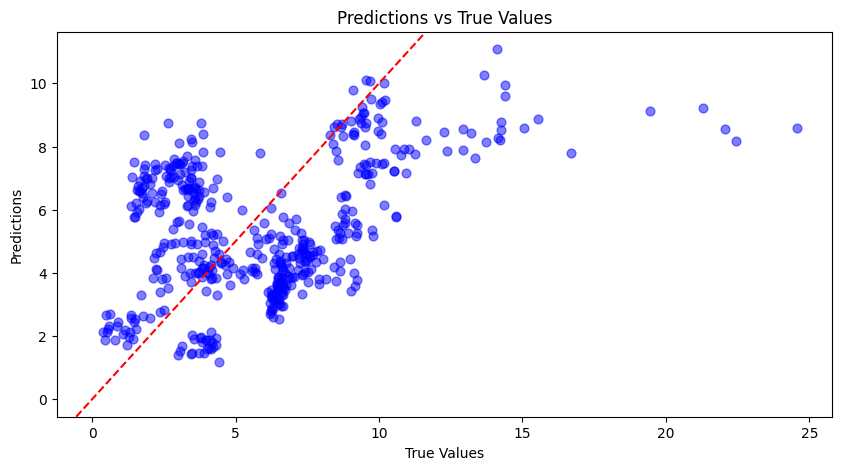

In [170]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

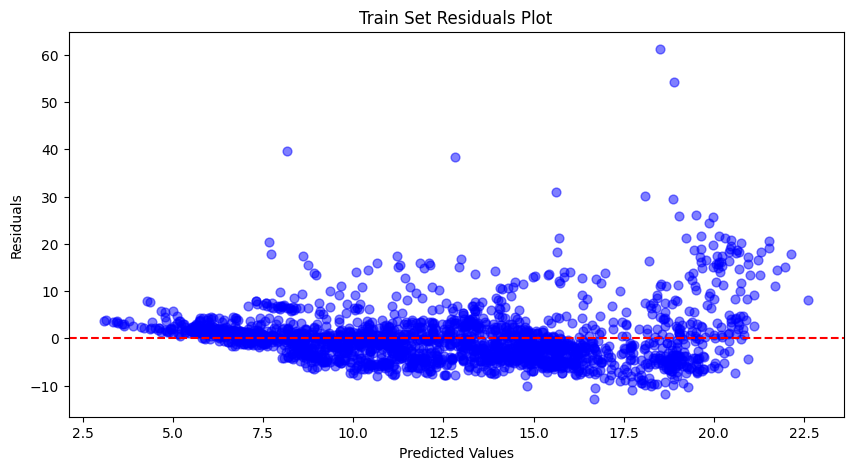

In [171]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, train_res, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Train Set Residuals Plot")
plt.show()

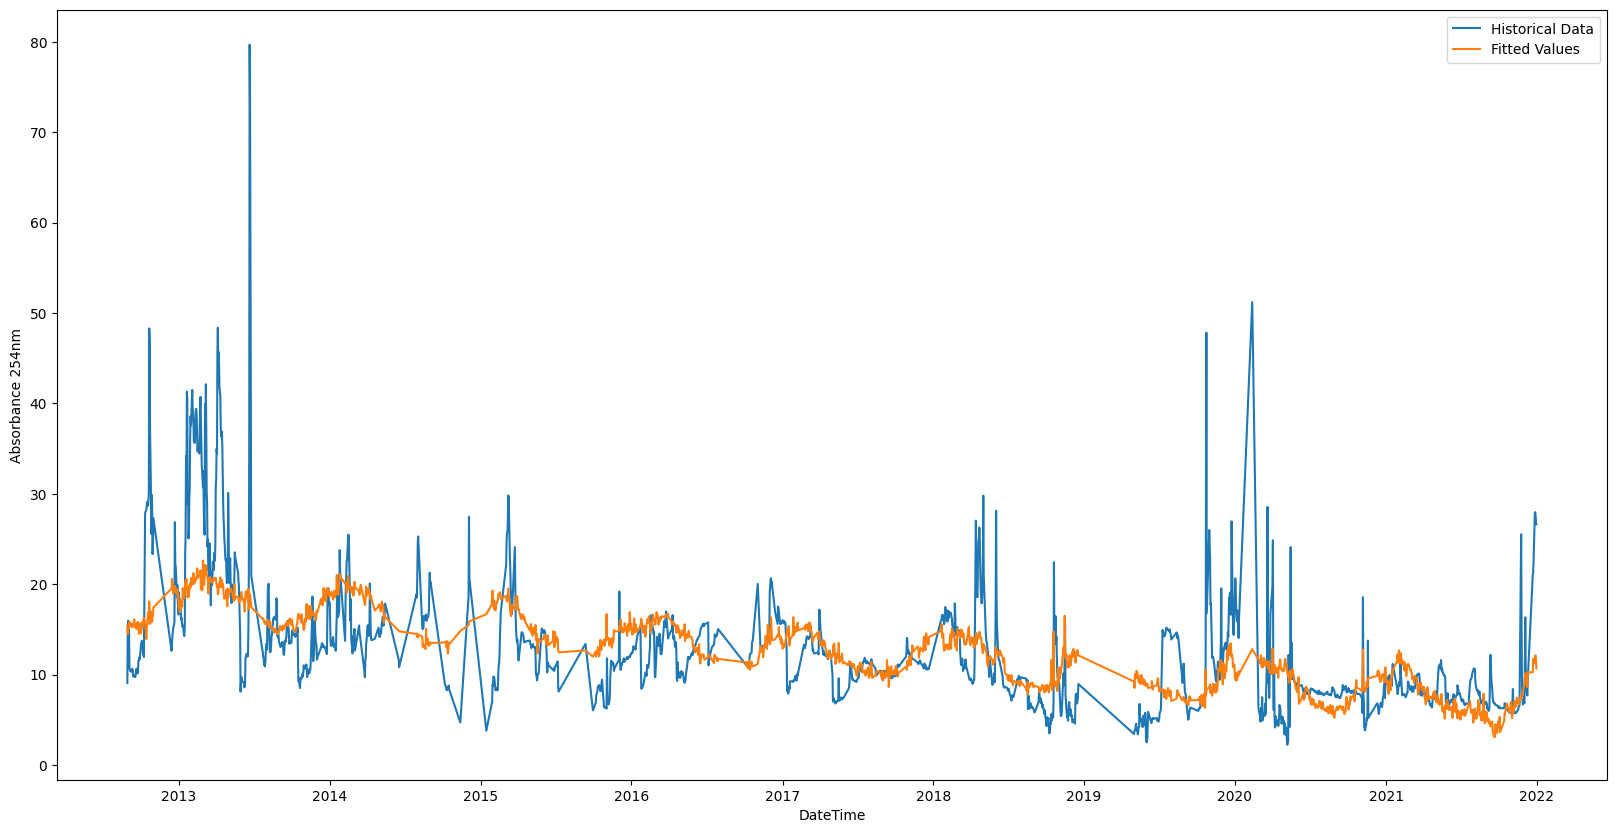

In [172]:
# plot the fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train["DateTime"],
    y=model.fittedvalues.values,
    label="Fitted Values",
)

plt.show()

In [173]:
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)

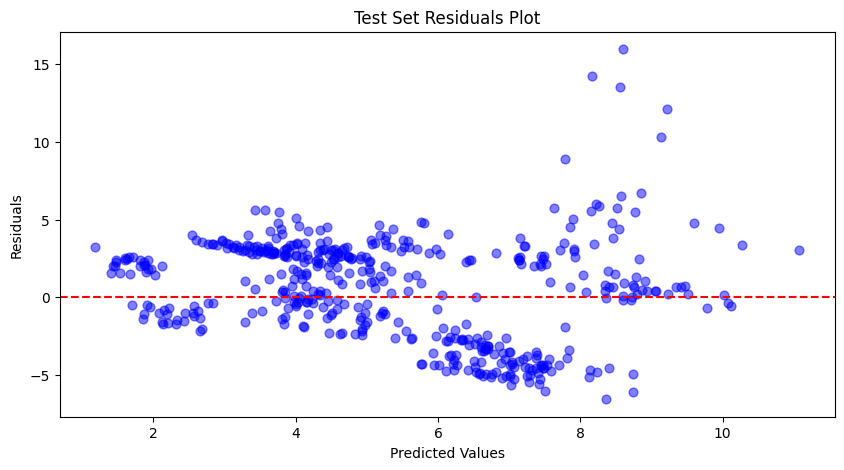

In [174]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

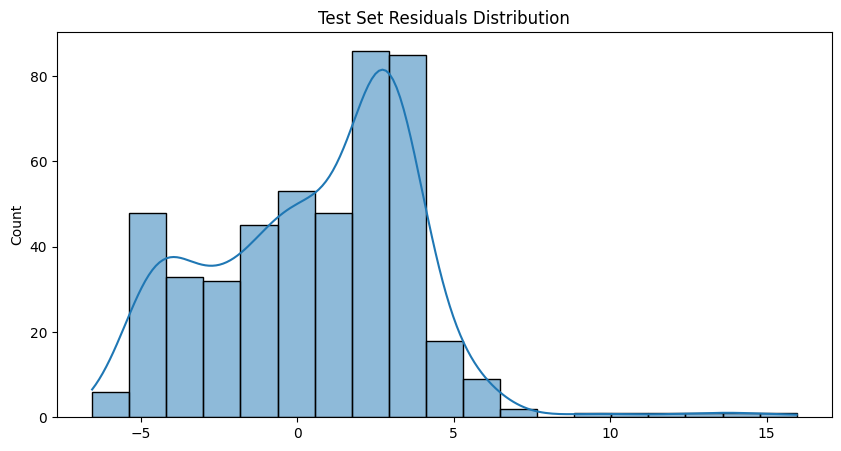

In [175]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

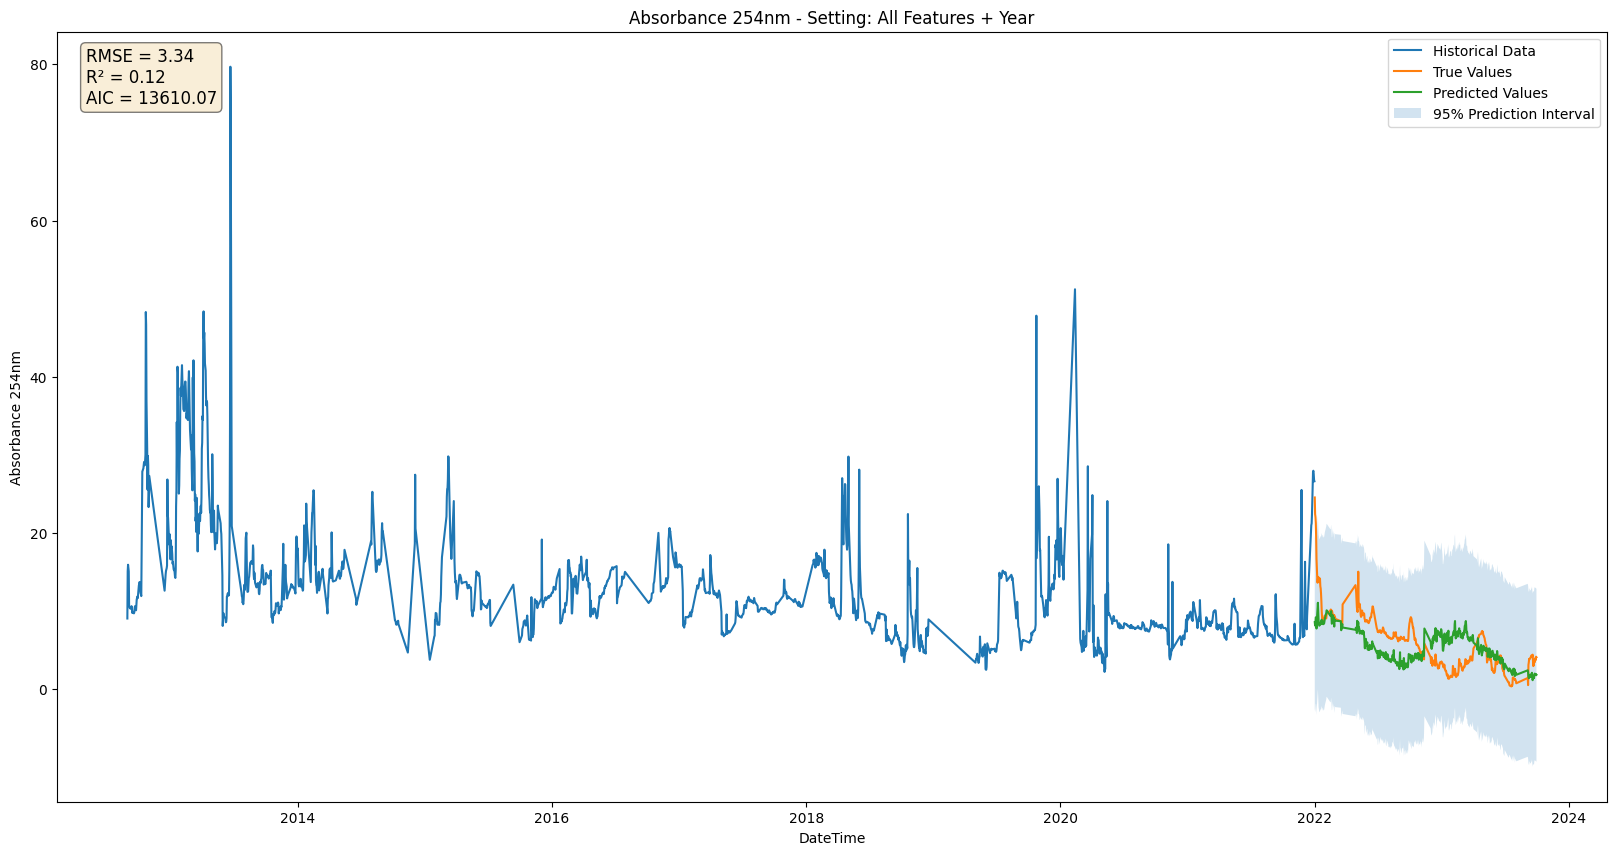

In [176]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

#### Store Results

In [177]:
lr_pred = predictions["mean"]
lr_lower_bound = predictions["obs_ci_lower"]
lr_upper_bound = predictions["obs_ci_upper"]
lr_rmse = rmse
lr_r2 = r2

## All Features + Year w/ log(y)

In [178]:
setting = "Ammonium + Flow River + Redox Potential + Turbidity + Year"

### Split Data

In [179]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

# scale y to ln(y)
y["Absorbance 254nm"] = np.log(y["Absorbance 254nm"])

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/122478304.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Absorbance 254nm'] = np.log(y['Absorbance 254nm'])


In [180]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [181]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

# scale the data
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(X_train_fit)
X_test_fit = scaler.transform(X_test_fit)

X_train_fit = pd.DataFrame(
    X_train_fit, columns=X_train.columns.difference(["DateTime"])
)
X_test_fit = pd.DataFrame(
    X_test_fit, columns=X_test.columns.difference(["DateTime"])
)

### Train Model

In [182]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [183]:
results = model.summary2()

### Results

In [184]:
print(results)

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.424    
Dependent Variable:    y                  AIC:                  1719.7833
Date:                  2024-03-18 18:10   BIC:                  1748.1749
No. Observations:      2161               Log-Likelihood:       -854.89  
Df Model:              4                  F-statistic:          398.1    
Df Residuals:          2156               Prob (F-statistic):   5.62e-257
R-squared:             0.425              Scale:                0.12946  
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                     2.4011   0.0077 310.2218 0.0000  2.3860  2.4163
Air Temperature           0.1123   0.0169   6.6333 0.0000  0.0791  0.1455
Daily Cumulated Rainfall  0.0147   0.0078   1.8897 0.0589 -

### Predictions

In [185]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [186]:
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.090393,0.020614,2.049968,2.130818,1.383626,2.797160
1,2.063540,0.020388,2.023558,2.103523,1.356799,2.770282
2,2.086600,0.019967,2.047445,2.125756,1.379905,2.793296
3,2.126041,0.020362,2.086110,2.165973,1.419302,2.832780
4,2.119825,0.020397,2.079826,2.159825,1.413083,2.826568
...,...,...,...,...,...,...
466,1.636912,0.021181,1.595374,1.678450,0.930081,2.343744
467,1.640027,0.020802,1.599232,1.680822,0.933239,2.346815
468,1.637325,0.020833,1.596470,1.678179,0.930533,2.344116
469,1.629944,0.021092,1.588582,1.671307,0.923123,2.336765


In [187]:
# rescale the data
y_train["Absorbance 254nm"] = np.exp(y_train["Absorbance 254nm"])
y_test["Absorbance 254nm"] = np.exp(y_test["Absorbance 254nm"])
y_test_fit = np.exp(y_test_fit)

predictions["mean"] = np.exp(predictions["mean"])
predictions["obs_ci_lower"] = np.exp(predictions["obs_ci_lower"])
predictions["obs_ci_upper"] = np.exp(predictions["obs_ci_upper"])

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/1204093844.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Absorbance 254nm'] = np.exp(y_train['Absorbance 254nm'])
/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_89623/1204093844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Absorbance 254nm'] = np.exp(y_test['Absorbance 254nm'])


### Plots

In [188]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 3.3095757937112653
R2: 0.13493363638206424


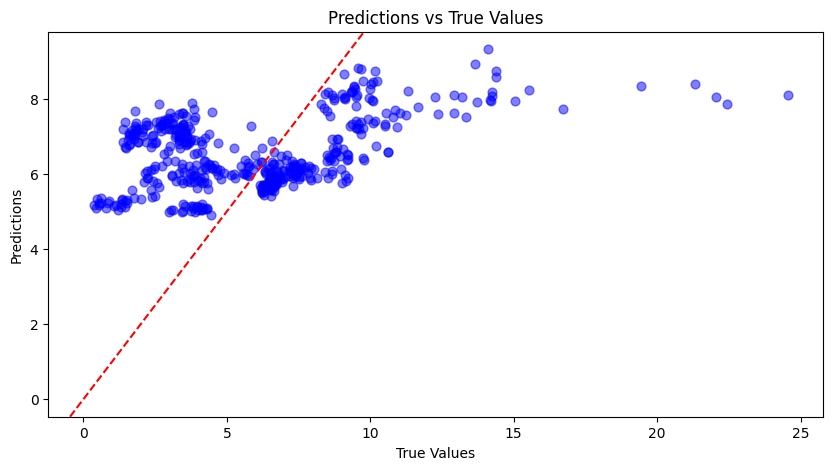

In [189]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

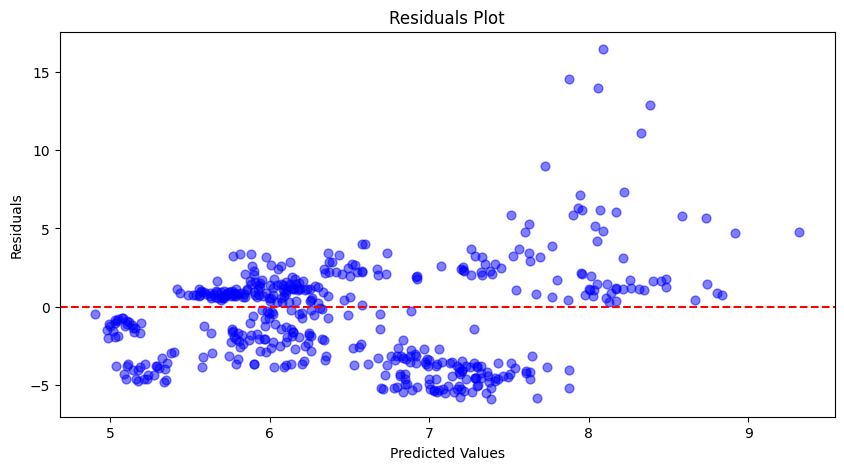

In [190]:
# plot the residuals
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

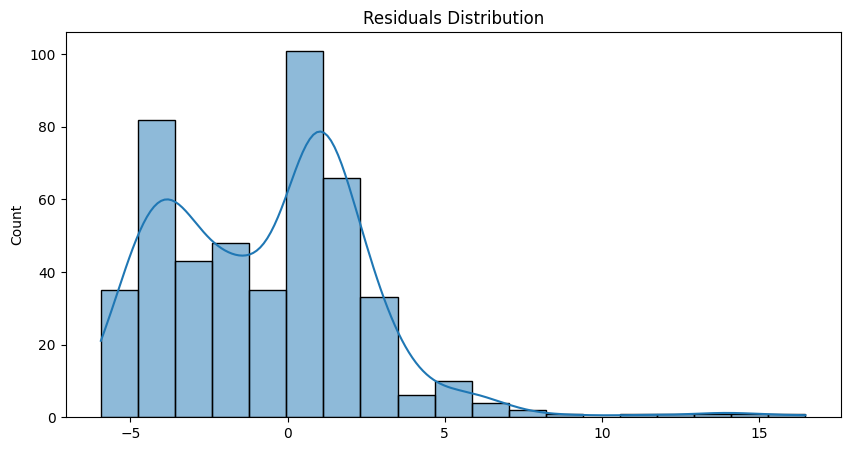

In [191]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

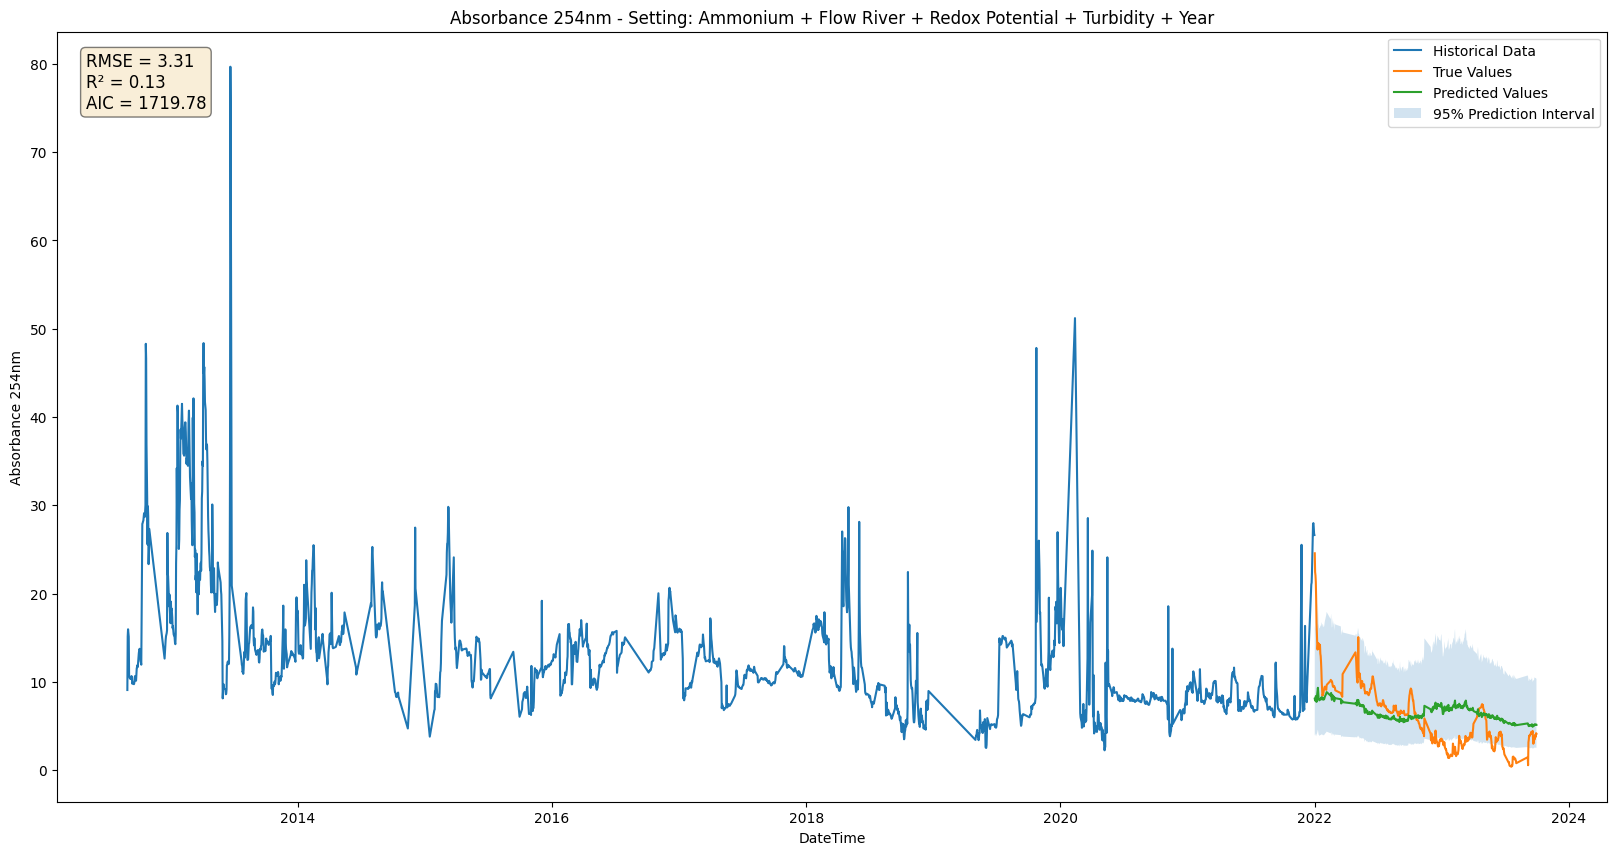

In [192]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

### Store Results

In [193]:
log_pred = predictions["mean"]
log_lower_bound = predictions["obs_ci_lower"]
log_upper_bound = predictions["obs_ci_upper"]
log_rmse = rmse
log_r2 = r2

## All Features + Year + Polynomial Features

### Split Data

In [194]:
further_features = ["Year", "Season", "Month", "Timestamp"]

to_drop = ["Timestamp", "Month", "Season"]

further_features = [
    feature for feature in further_features if feature not in to_drop
]

X_columns_to_drop = to_drop + ["Absorbance 254nm"]

X = full_df[full_df.columns.difference(X_columns_to_drop)]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [195]:
# add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_poly = poly.fit_transform(
    X[X.columns.difference(["DateTime"] + further_features)]
)

X_poly = pd.DataFrame(
    X_poly,
    columns=poly.get_feature_names_out(
        X.columns.difference(["DateTime"] + further_features)
    ),
)

X_poly["DateTime"] = X["DateTime"].values

X_poly[further_features] = X[further_features].values

In [196]:
# split data such that 2022 and 2023 are test data
X_train = X_poly[X_poly["DateTime"] < "2022-01-01"]
X_test = X_poly[X_poly["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [197]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [198]:
scaler = StandardScaler()

X_train_fit = scaler.fit_transform(
    X_train_fit[X_train_fit.columns.difference(further_features)]
)
X_test_fit = scaler.transform(
    X_test_fit[X_test_fit.columns.difference(further_features)]
)

X_train_fit = pd.DataFrame(
    X_train_fit,
    columns=X_train.columns.difference(["DateTime"] + further_features),
)
X_test_fit = pd.DataFrame(
    X_test_fit,
    columns=X_test.columns.difference(["DateTime"] + further_features),
)

X_train_fit[further_features] = X_train[further_features].values
X_test_fit[further_features] = X_test[further_features].values

### Train Model

In [199]:
model = sm.OLS(y_train_fit.values, sm.add_constant(X_train_fit)).fit()

In [200]:
results = model.summary2()

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


### Results

In [201]:
print(results)

                                 Results: Ordinary least squares
Model:                        OLS                        Adj. R-squared:               0.391     
Dependent Variable:           y                          AIC:                          13504.2497
Date:                         2024-03-18 18:10           BIC:                          13566.7113
No. Observations:             2161                       Log-Likelihood:               -6741.1   
Df Model:                     10                         F-statistic:                  139.7     
Df Residuals:                 2150                       Prob (F-statistic):           2.52e-225 
R-squared:                    0.394                      Scale:                        30.148    
-------------------------------------------------------------------------------------------------
                                             Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------

### Predictions

In [202]:
# predict the model
predictions = model.get_prediction(
    sm.add_constant(X_test_fit)
).summary_frame(alpha=0.05)

In [203]:
train_res = model.resid

### Plots

In [204]:
rmse = np.sqrt(mean_squared_error(y_test_fit, predictions["mean"]))
r2 = r2_score(y_test_fit, predictions["mean"])

print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 3.2170431857665704
R2: 0.18263028062945053


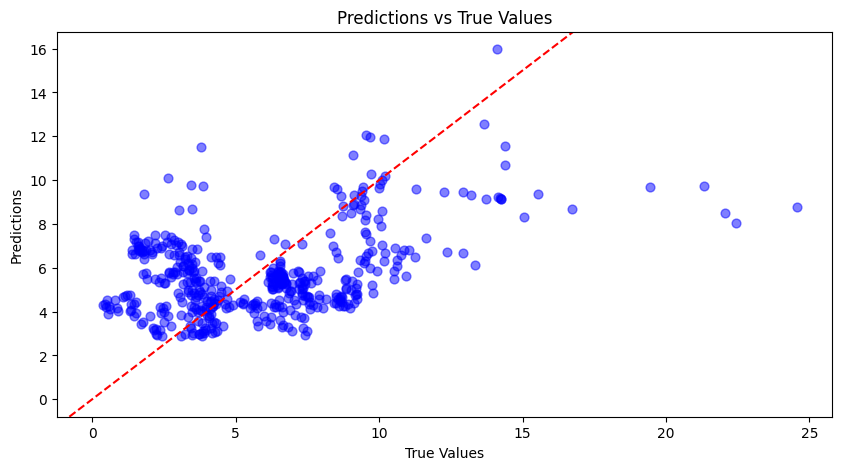

In [205]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, predictions["mean"], c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

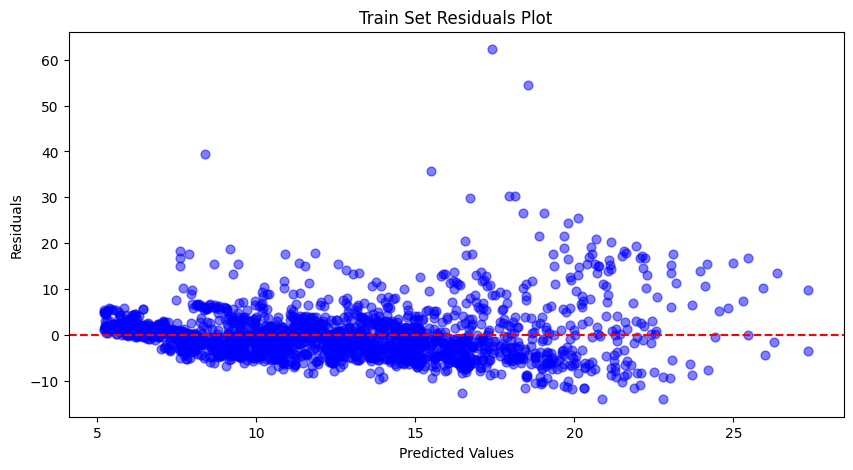

In [206]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, train_res, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Train Set Residuals Plot")
plt.show()

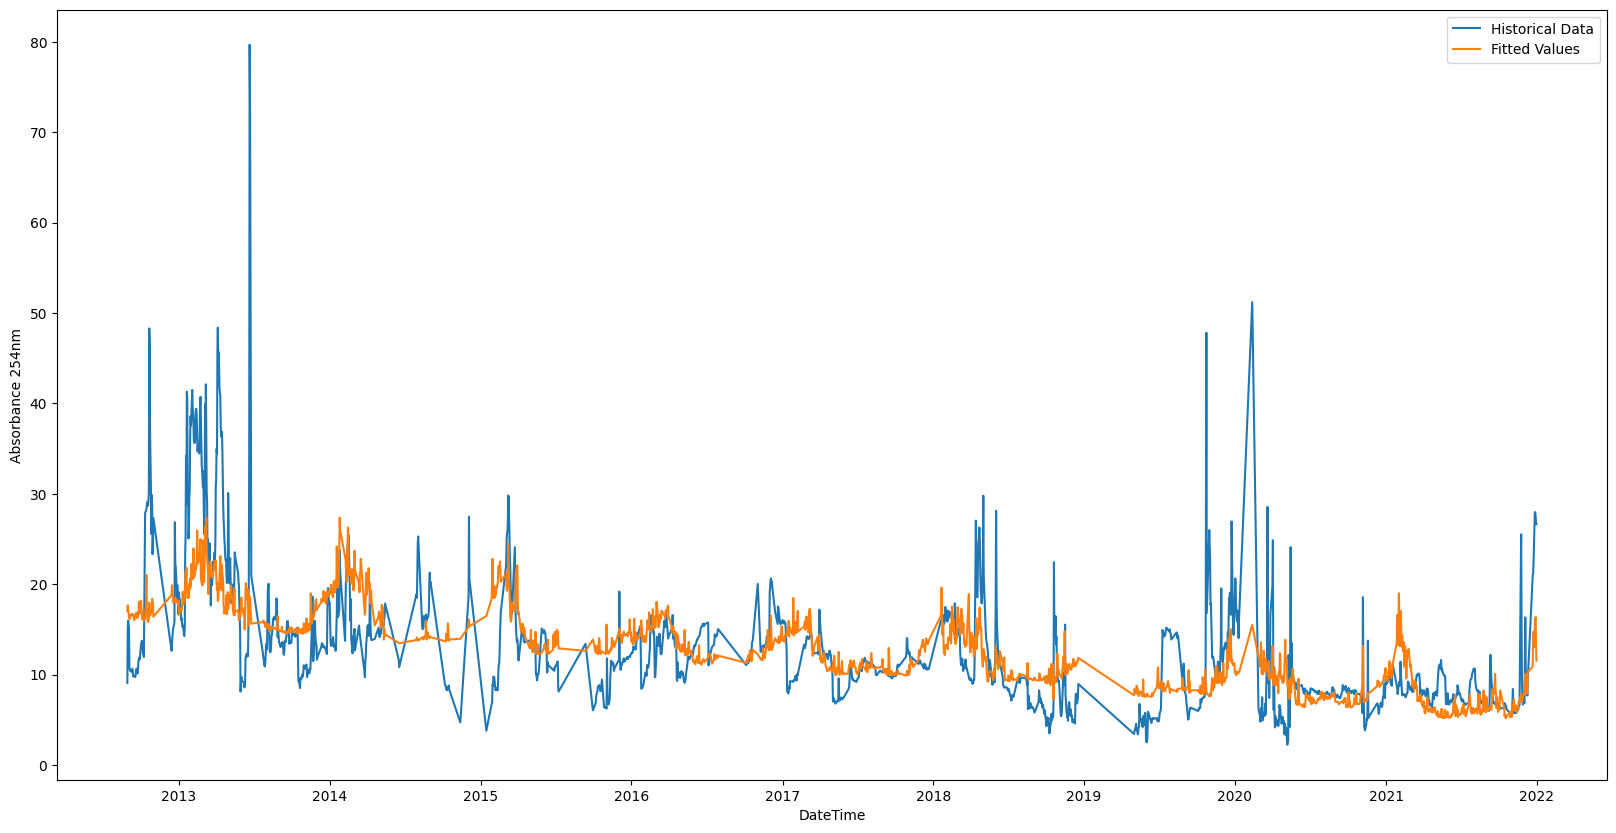

In [207]:
# plot the fitted values
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_train["DateTime"],
    y=model.fittedvalues.values,
    label="Fitted Values",
)

plt.show()

In [208]:
residuals = (
    y_test_fit["Absorbance 254nm"].values - predictions["mean"].values
)

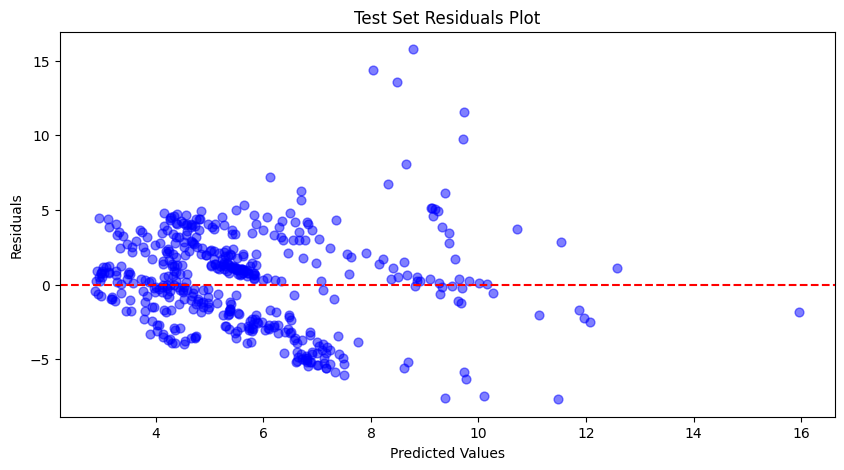

In [209]:
# plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(predictions["mean"], residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

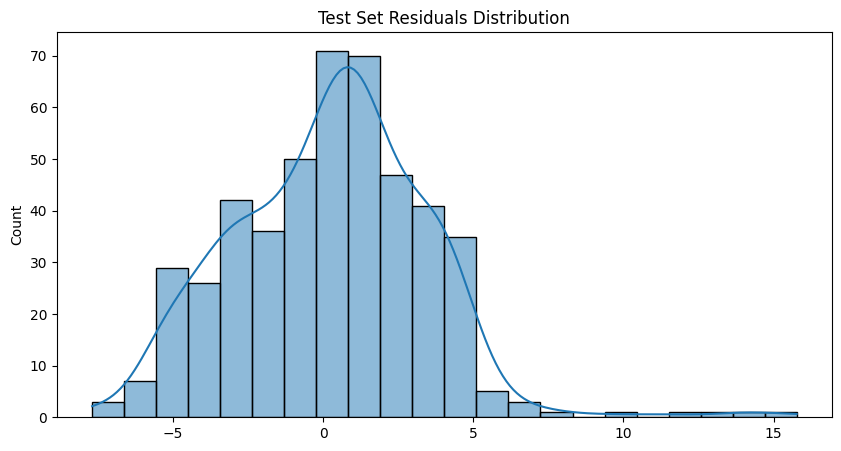

In [210]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

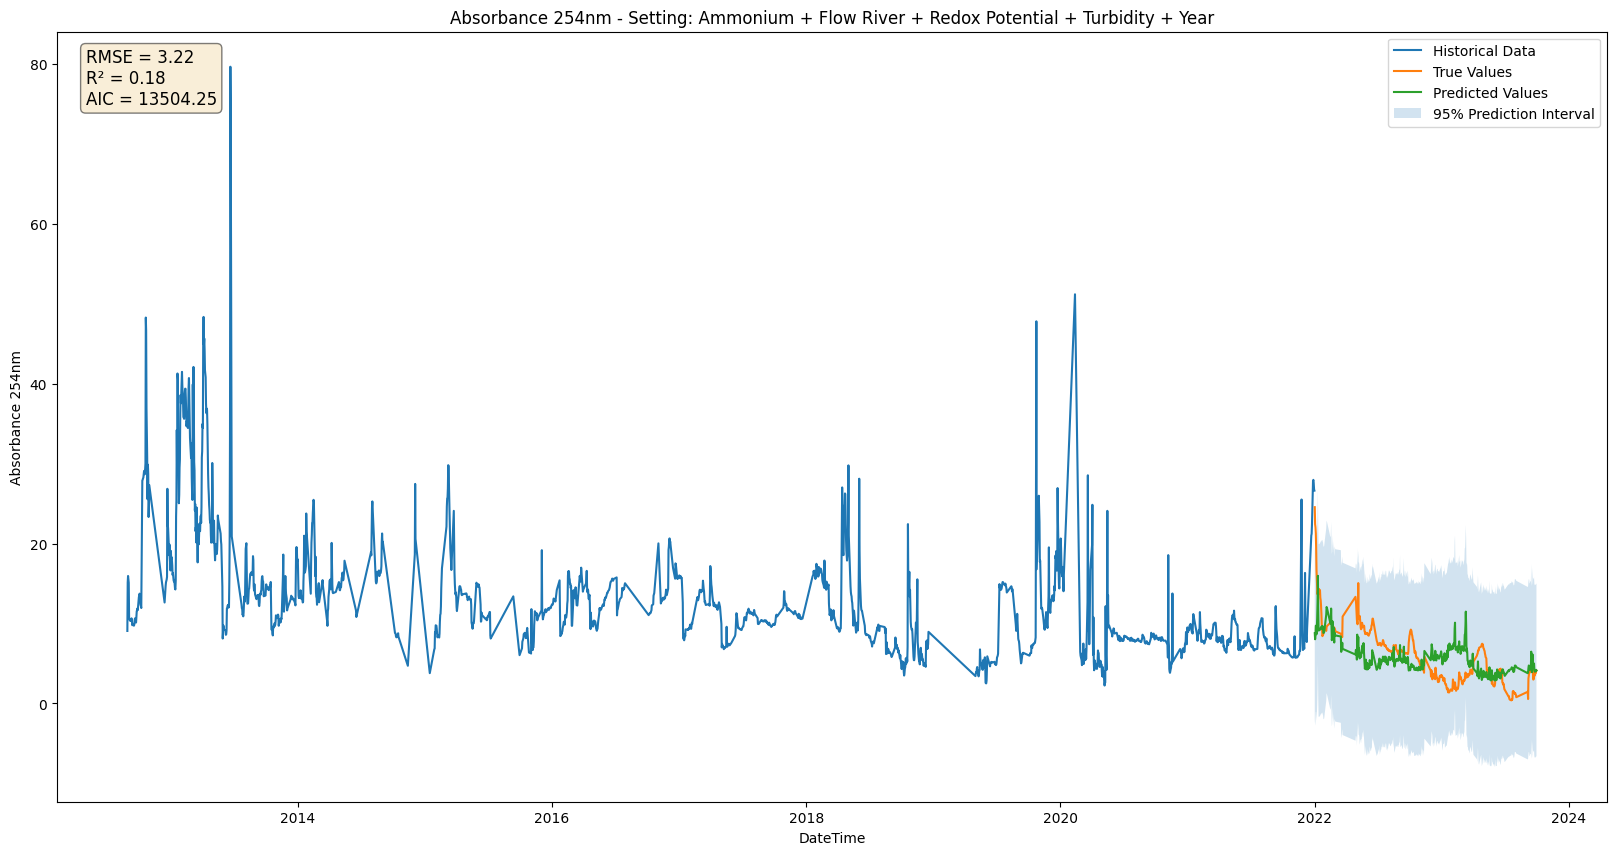

In [211]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
# sns.lineplot(x=y_train['DateTime'], y=model.fittedvalues.values, label='Fitted Values')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=predictions["mean"].values,
    label="Predicted Values",
)
plt.fill_between(
    y_test["DateTime"],
    predictions["obs_ci_lower"],
    predictions["obs_ci_upper"],
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
        f"AIC = {model.aic:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

### Store Results

In [212]:
poly_pred = predictions["mean"]
poly_lower_bound = predictions["obs_ci_lower"]
poly_upper_bound = predictions["obs_ci_upper"]
poly_rmse = rmse
poly_r2 = r2

## Final Plot

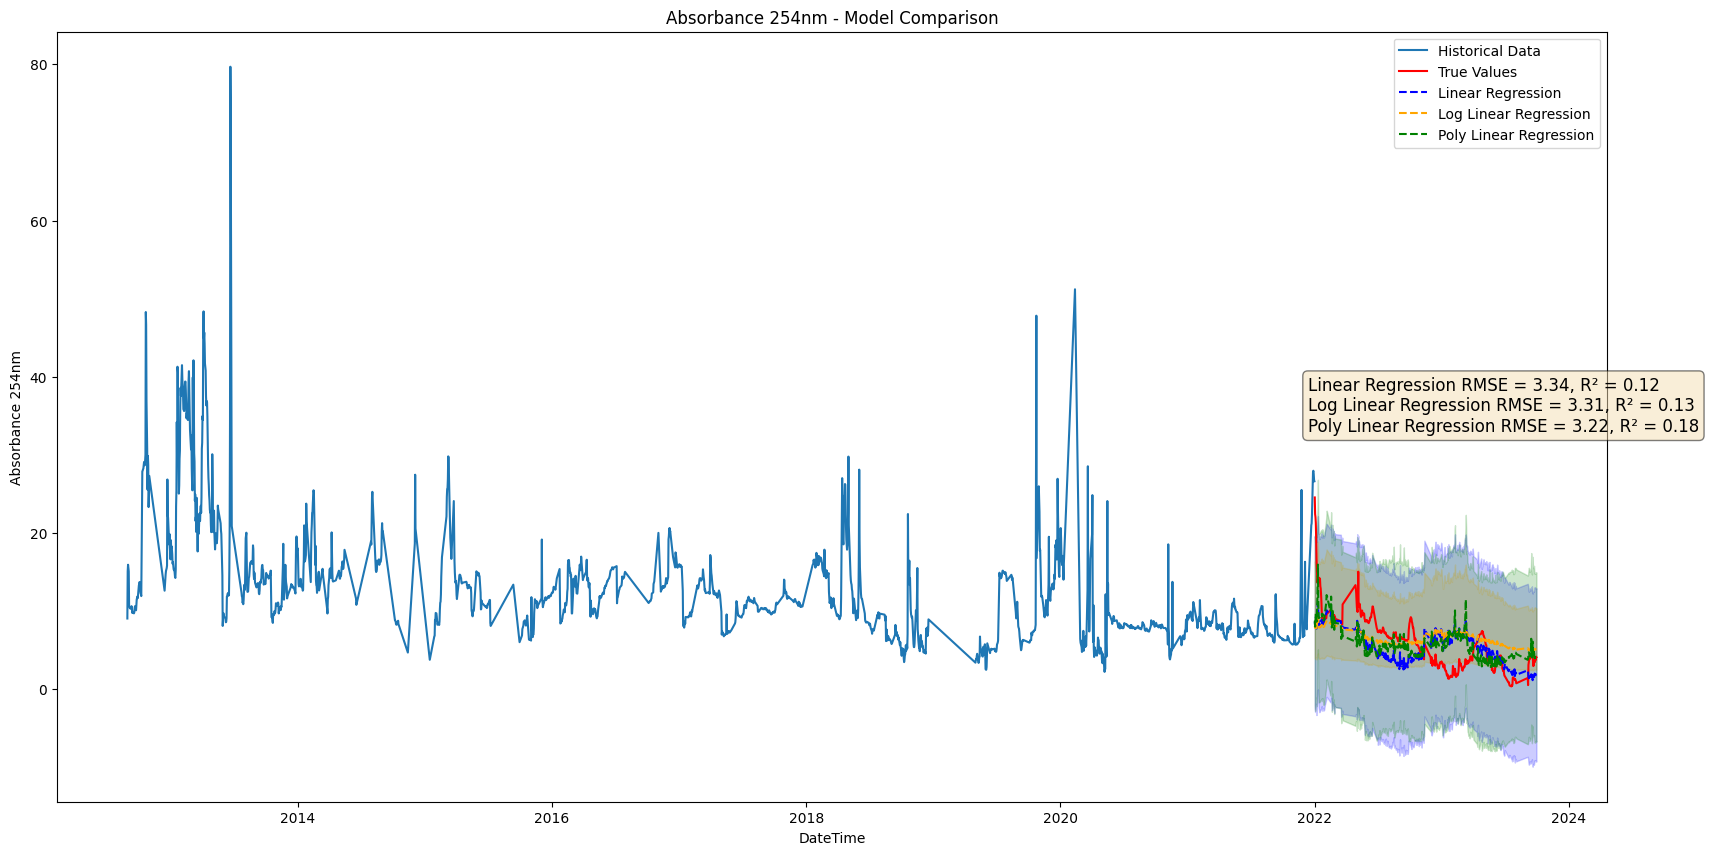

In [213]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=lr_pred.values,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    lr_lower_bound,
    lr_upper_bound,
    alpha=0.2,
    color="blue",
)

# Linear Regression Log
sns.lineplot(
    x=y_test["DateTime"],
    y=log_pred.values,
    label="Log Linear Regression",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    log_lower_bound,
    log_upper_bound,
    alpha=0.2,
    color="orange",
)

# Linear Regression Poly
sns.lineplot(
    x=y_test["DateTime"],
    y=poly_pred.values,
    label="Poly Linear Regression",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    poly_lower_bound,
    poly_upper_bound,
    alpha=0.2,
    color="green",
)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Linear Regression RMSE = {lr_rmse:.2f}, R\u00b2 = {lr_r2:.2f}",
        f"Log Linear Regression RMSE = {log_rmse:.2f}, R\u00b2 = {log_r2:.2f}",
        f"Poly Linear Regression RMSE = {poly_rmse:.2f}, R\u00b2 = {poly_r2:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    33,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Model Comparison")

plt.legend()
plt.show()

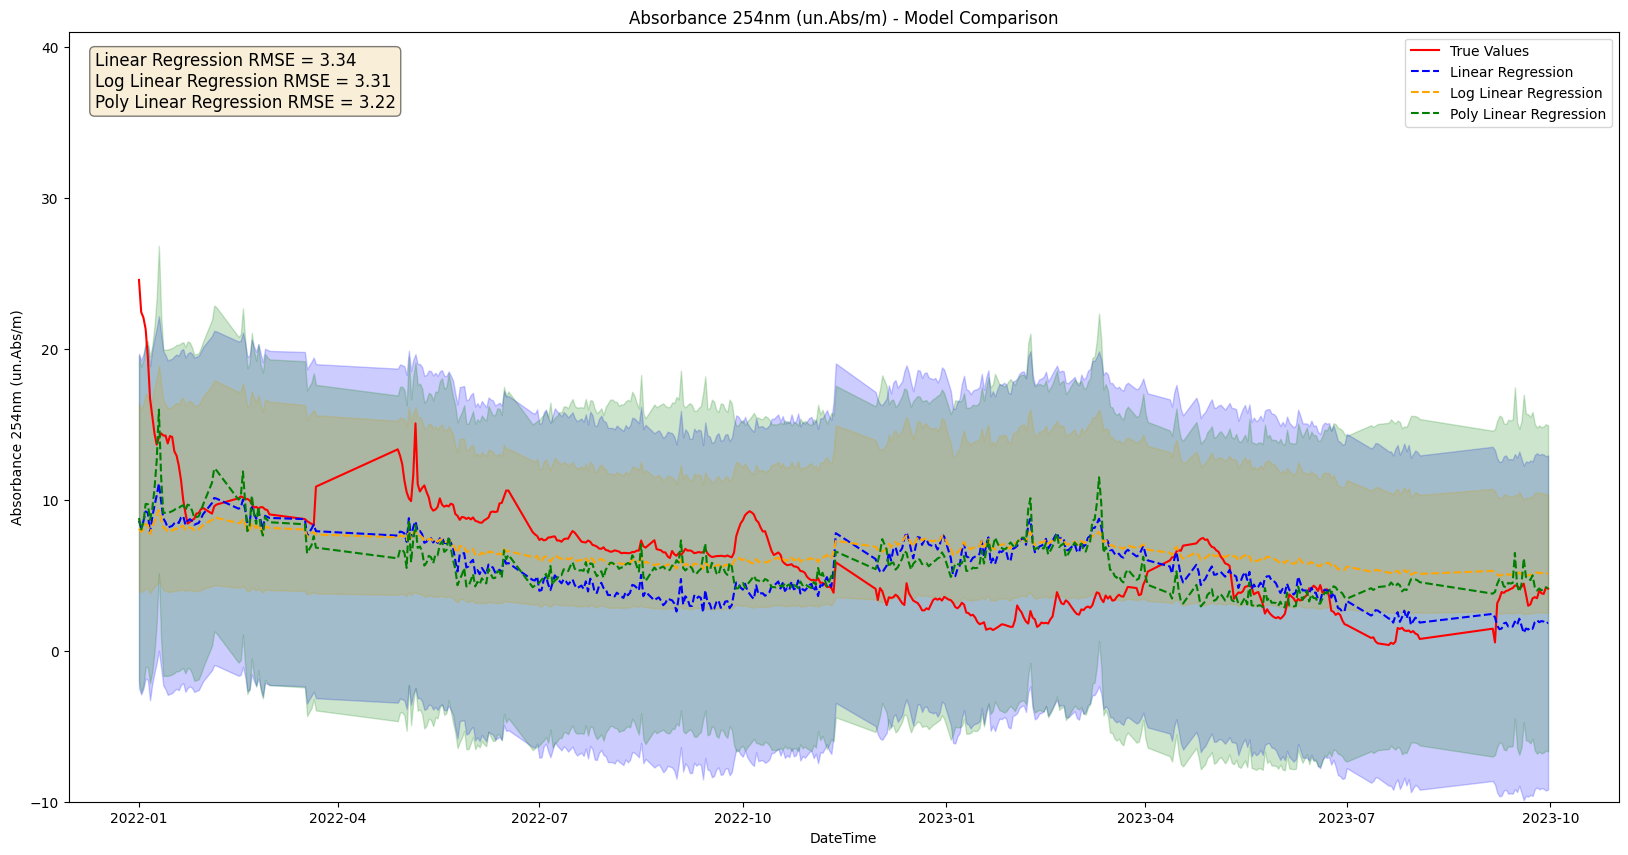

In [214]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=lr_pred.values,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    lr_lower_bound,
    lr_upper_bound,
    alpha=0.2,
    color="blue",
)

# Linear Regression Log
sns.lineplot(
    x=y_test["DateTime"],
    y=log_pred.values,
    label="Log Linear Regression",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    log_lower_bound,
    log_upper_bound,
    alpha=0.2,
    color="orange",
)

# Linear Regression Poly
sns.lineplot(
    x=y_test["DateTime"],
    y=poly_pred.values,
    label="Poly Linear Regression",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    poly_lower_bound,
    poly_upper_bound,
    alpha=0.2,
    color="green",
)

# change the y range to see the differences
plt.ylim(-10, 41)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm (un.Abs/m)")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Linear Regression RMSE = {lr_rmse:.2f}",
        f"Log Linear Regression RMSE = {log_rmse:.2f}",
        f"Poly Linear Regression RMSE = {poly_rmse:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    36,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm (un.Abs/m) - Model Comparison")

plt.legend()
plt.show()

# Random Forest

In [44]:
setting = "All Features + Year"

### Split Data

In [45]:
X = full_df[
    full_df.columns.difference(
        ["Absorbance 254nm", "Season", "Month", "Timestamp"]
    )
]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [46]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [47]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

### Train Model

#### Perform K-Fold Cross-Validation

K = 10 since the training set is composed of 10 years (almost).

In [48]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [49]:
rf_model = RandomForestQuantileRegressor(
    n_estimators=20, max_features="log2", max_depth=7, random_state=42
)

cv = KFold(n_splits=10)

rf_ensemble = cross_validate(
    rf_model,
    X_train_fit,
    y_train_fit.values.flatten(),
    cv=cv,
    scoring="neg_mean_squared_error",
    return_estimator=True,
    return_train_score=True,
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

### Results

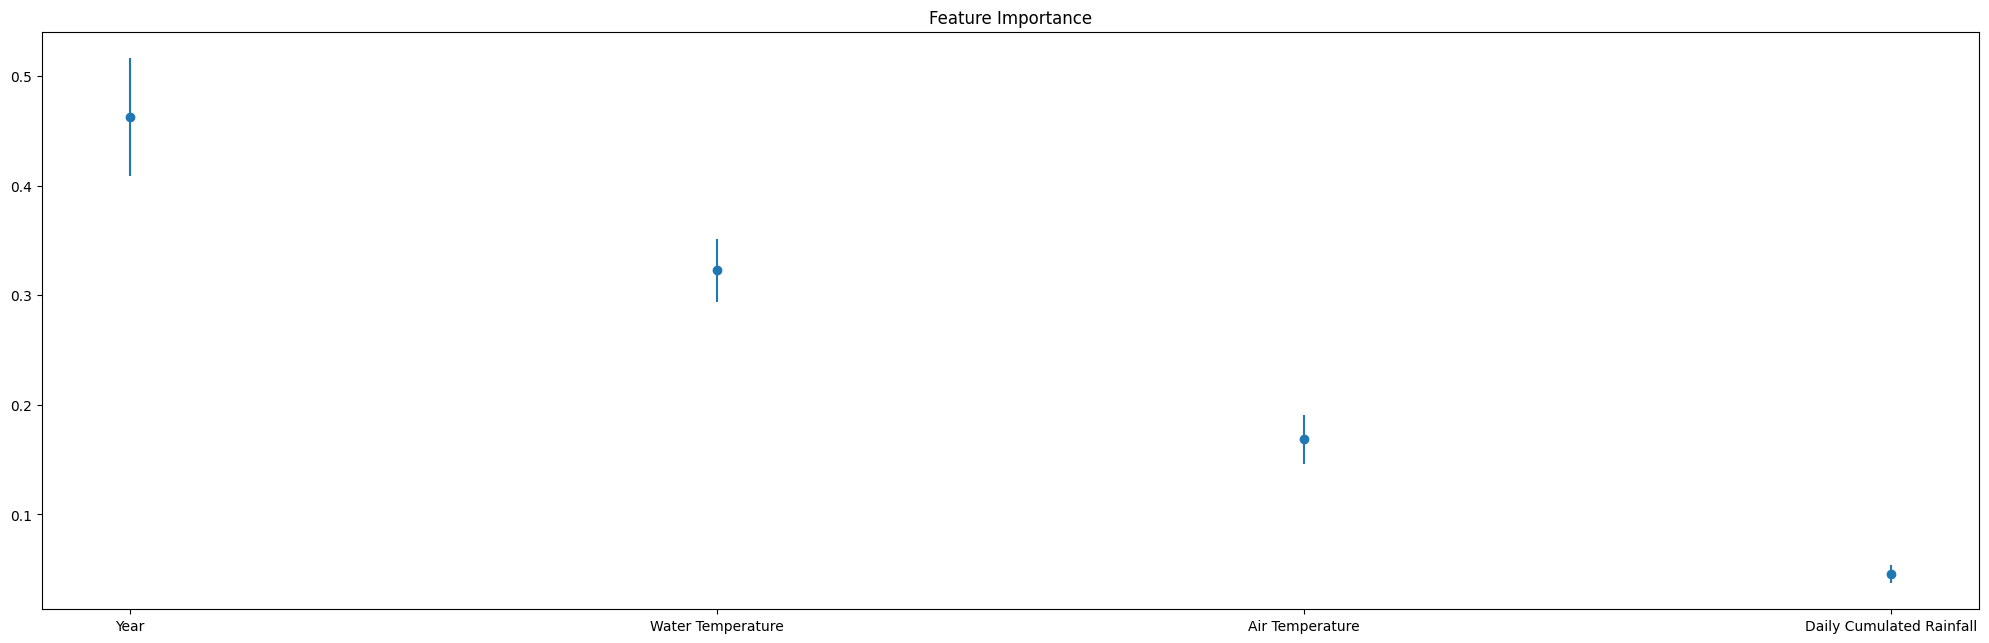

In [50]:
# show the importance of each feature in the model
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train_fit.columns
feature_importance["importance_mean"] = np.mean(
    [
        estimator.feature_importances_
        for estimator in rf_ensemble["estimator"]
    ],
    axis=0,
)
feature_importance["importance_std"] = np.std(
    [
        estimator.feature_importances_
        for estimator in rf_ensemble["estimator"]
    ],
    axis=0,
)

feature_importance = feature_importance.sort_values(
    by="importance_mean", ascending=False
)

# plot the importance of each feature with the std
plt.figure(figsize=(25, 7.5))
plt.errorbar(
    x=feature_importance["feature"],
    y=feature_importance["importance_mean"],
    yerr=feature_importance["importance_std"],
    fmt="o",
)
plt.title("Feature Importance")
plt.show()

### Predictions

In [51]:
# get predictions
mean_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.5)
        for estimator in rf_ensemble["estimator"]
    ]
)
lower_bound_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.05)
        for estimator in rf_ensemble["estimator"]
    ]
)
upper_bound_predictions = np.array(
    [
        estimator.predict(X_test_fit, quantiles=0.95)
        for estimator in rf_ensemble["estimator"]
    ]
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

In [52]:
mean_predictions = np.mean(mean_predictions, axis=0)
lower_bound_predictions = np.mean(lower_bound_predictions, axis=0)
upper_bound_predictions = np.mean(upper_bound_predictions, axis=0)

In [53]:
rmse = np.sqrt(mean_squared_error(y_test_fit, mean_predictions))
r2 = r2_score(y_test_fit, mean_predictions)

print(f"RMSE: {rmse:.2f}")
print(f"R\u00b2: {r2:.2f}")

RMSE: 4.17
R²: -0.38


### Plots

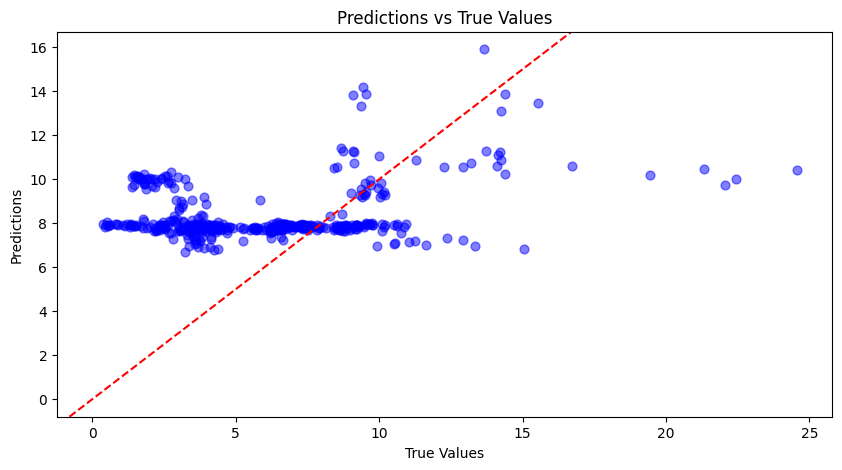

In [54]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit.values, mean_predictions, c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

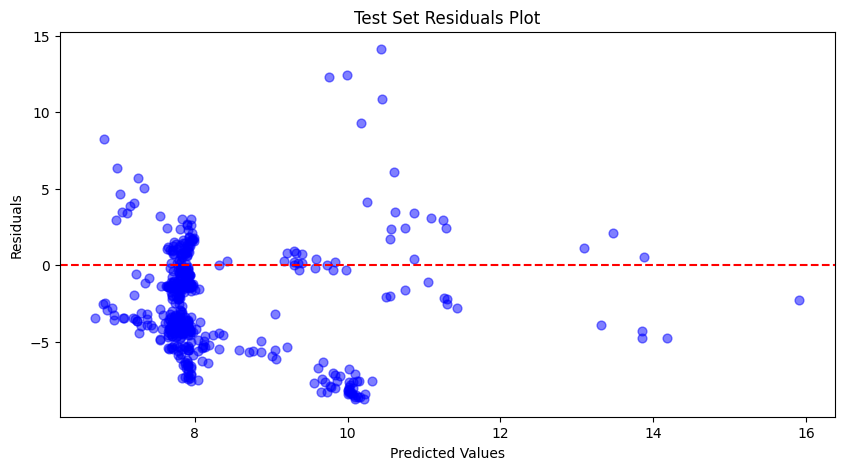

In [55]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - mean_predictions
plt.figure(figsize=(10, 5))
plt.scatter(mean_predictions, residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

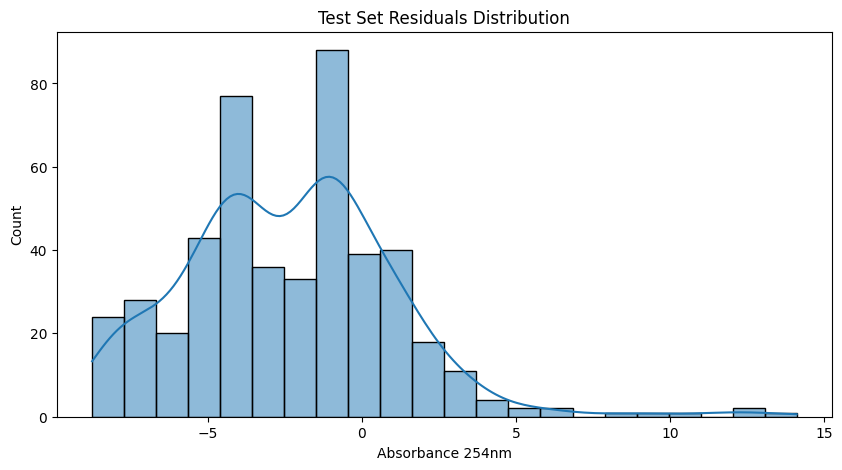

In [56]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [57]:
# get training residuals
train_predictions = np.array(
    [
        estimator.predict(X_train_fit, quantiles=0.5)
        for estimator in rf_ensemble["estimator"]
    ]
)
train_predictions = np.mean(train_predictions, axis=0)

train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted wit

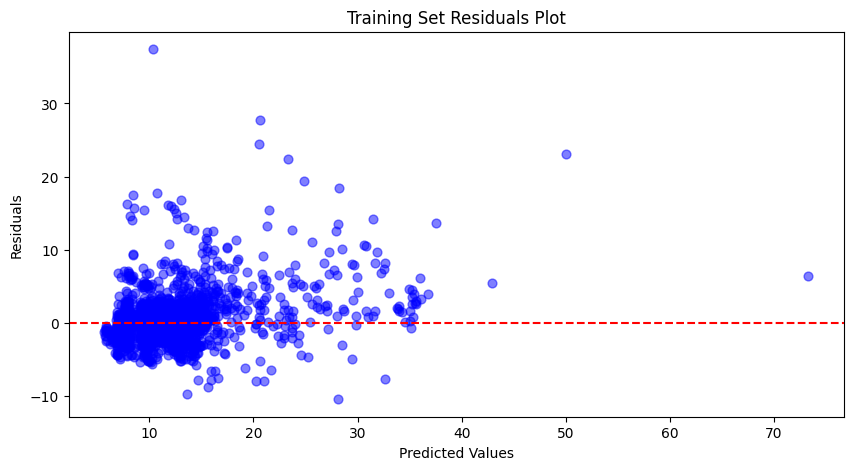

In [58]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(train_predictions, train_residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

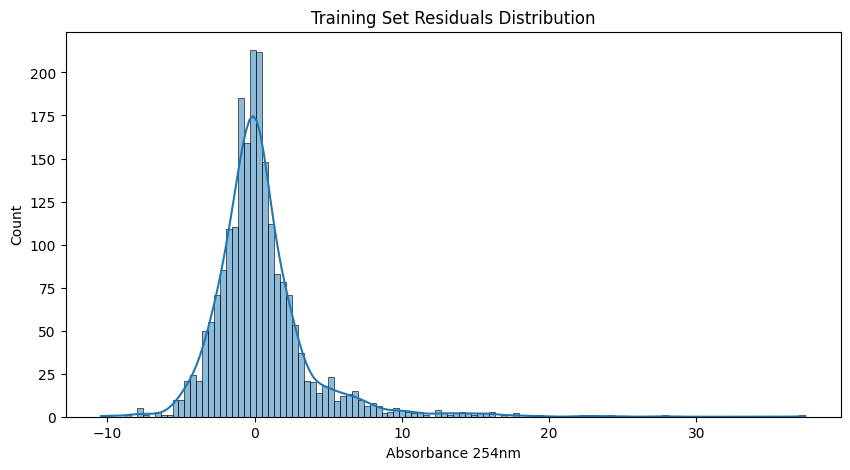

In [59]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

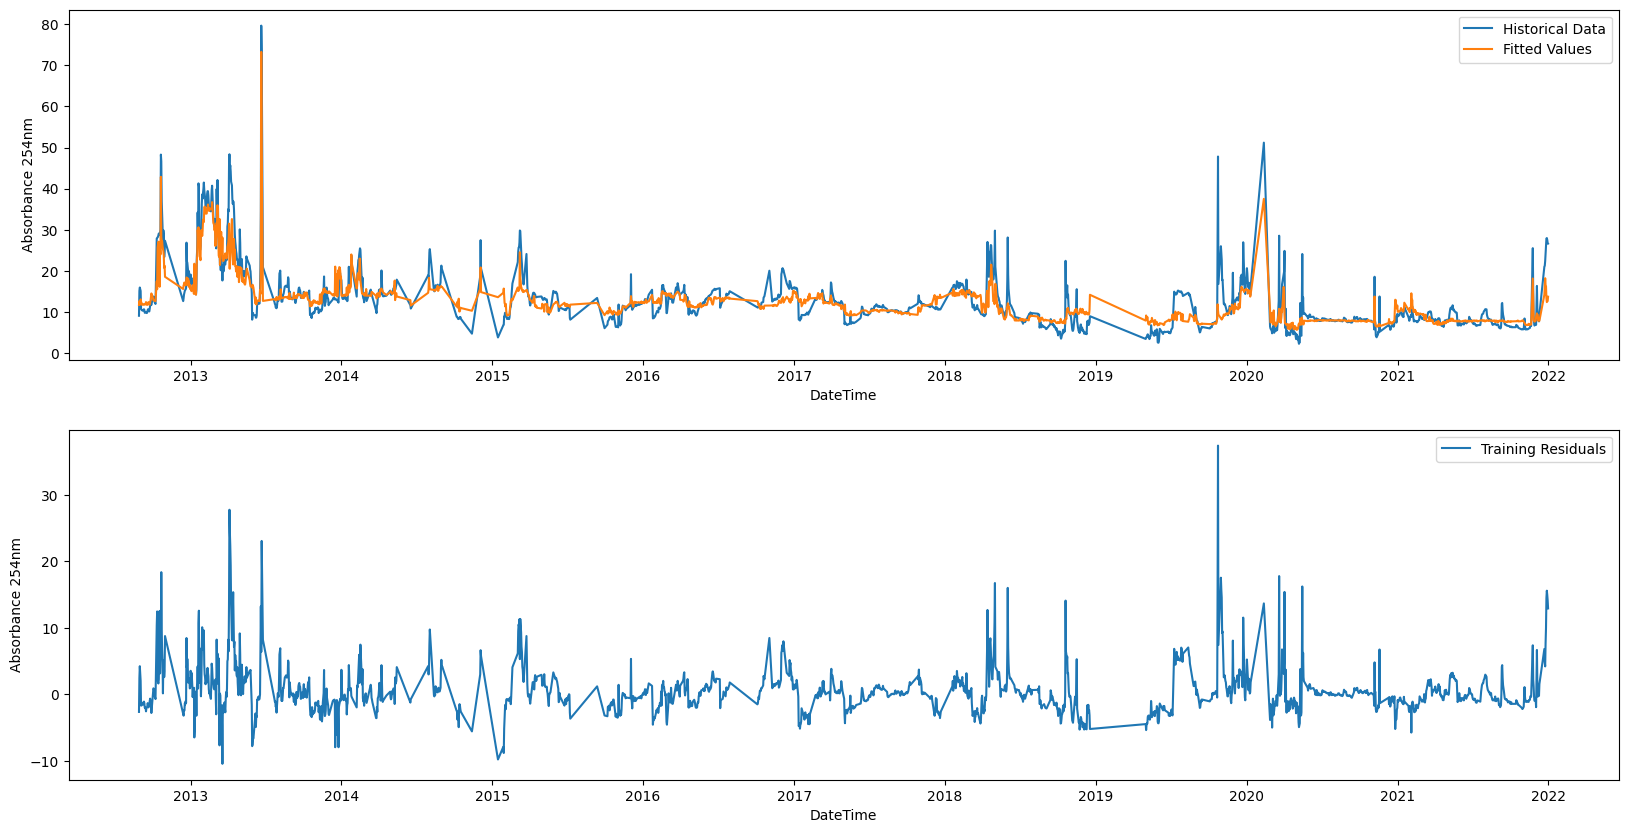

In [60]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
    ax=ax[0],
)
sns.lineplot(
    x=y_train["DateTime"],
    y=train_predictions,
    label="Fitted Values",
    ax=ax[0],
)

sns.lineplot(
    x=y_train["DateTime"],
    y=train_residuals,
    label="Training Residuals",
    ax=ax[1],
)

plt.show()

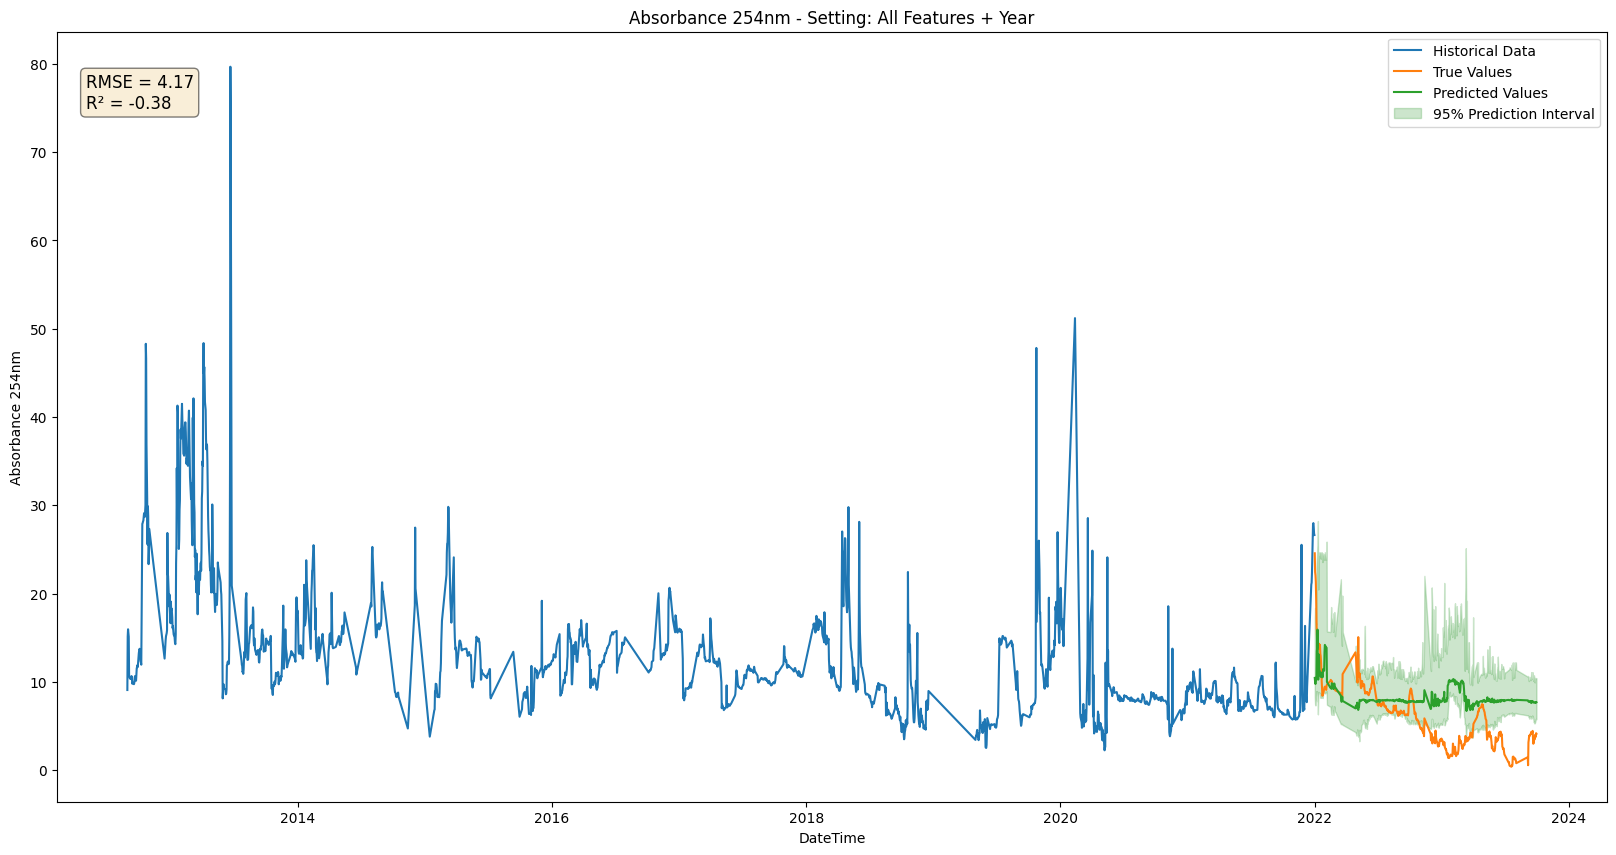

In [61]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(
    x=y_test["DateTime"], y=mean_predictions, label="Predicted Values"
)
# plot std of predictions
plt.fill_between(
    y_test["DateTime"],
    lower_bound_predictions,
    y2=upper_bound_predictions,
    alpha=0.2,
    label="95% Prediction Interval",
    color="g",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

Comment: prevede un trend crescente, probabilmente dato da qualche feature 

### Store Results

In [62]:
rf_pred = mean_predictions
rf_lower_bound = lower_bound_predictions
rf_upper_bound = upper_bound_predictions
rf_rmse = rmse
rf_r2 = r2

# Neural Network

In [63]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Split Data

In [64]:
def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train), columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test), columns=x_test.columns
    )
    return x_train_scaled, x_test_scaled

In [65]:
X = full_df[
    full_df.columns.difference(
        ["Absorbance 254nm", "Season", "Month", "Timestamp"]
    )
]

y = full_df[["DateTime", "Absorbance 254nm"]]

In [66]:
# split data such that 2022 and 2023 are test data
X_train = X[X["DateTime"] < "2022-01-01"]
X_test = X[X["DateTime"] >= "2022-01-01"]

y_train = y[y["DateTime"] < "2022-01-01"]
y_test = y[y["DateTime"] >= "2022-01-01"]

In [67]:
X_train_fit = X_train[X_train.columns.difference(["DateTime"])]
X_test_fit = X_test[X_test.columns.difference(["DateTime"])]

y_train_fit = y_train[y_train.columns.difference(["DateTime"])]
y_test_fit = y_test[y_test.columns.difference(["DateTime"])]

In [68]:
X_train_scaled, X_test_scaled = scale_datasets(X_train_fit, X_test_fit)

## Define the model

In [69]:
# define and fit the model
def fit_model(X_train, y_train):
    # define neural network model
    features = X_train.shape[1]
    model = Sequential()
    model.add(
        Dense(
            10,
            kernel_initializer="he_normal",
            activation="relu",
            input_dim=features,
        )
    )
    model.add(Dense(1))
    # compile the model and specify loss and optimizer
    opt = Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
    model.compile(optimizer=opt, loss="mse")
    # fit the model on the training dataset
    model.fit(X_train, y_train, verbose=0, epochs=300, batch_size=16)
    return model

In [70]:
# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
    ensemble = list()
    for i in range(n_members):
        # define and fit the model on the training set
        model = fit_model(X_train, y_train)
        # evaluate model on the test set
        yhat = model.predict(X_test, verbose=0)
        rmse = np.sqrt(mean_squared_error(y_test, yhat))
        print(">%d, RMSE: %.3f" % (i + 1, rmse))
        # store the model
        ensemble.append(model)
    return ensemble

In [71]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
    # make predictions
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.asarray(yhat)
    yhat = yhat.reshape(yhat.shape[0], yhat.shape[1])
    # calculate 95% gaussian prediction interval
    stds = np.std(yhat, axis=0)
    interval = 1.96 * stds
    means = np.mean(yhat, axis=0)
    lower, upper = means - interval, means + interval
    return lower, means, upper

In [72]:
%%script false --no-raise-error
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

In [73]:
%%script false --no-raise-error
model = build_model_using_sequential()

In [74]:
%%script false --no-raise-error
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)

## Train the model

In [75]:
%%script false --no-raise-error
history = model.fit(
    X_train_scaled.values, 
    y_train_fit.values, 
    epochs=50, 
    batch_size=64,
    validation_split=0.2,
    verbose=1,
)

In [76]:
%%script false --no-raise-error
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [77]:
n_members = 10

ensemble = fit_ensemble(
    n_members,
    X_train_scaled.values,
    X_test_scaled.values,
    y_train_fit.values,
    y_test_fit.values,
)

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>1, RMSE: 3.504


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>2, RMSE: 4.257


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>3, RMSE: 3.540


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>4, RMSE: 4.841


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>5, RMSE: 3.212


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>6, RMSE: 3.470


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>7, RMSE: 5.876


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>8, RMSE: 4.157


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>9, RMSE: 5.940


/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/climate-change-MEYtuKH4-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


>10, RMSE: 3.582


## Prediction

In [78]:
%%script false --no-raise-error
y_pred = model.predict(X_test_scaled)

In [79]:
(lower_bound, y_pred, upper_bound) = predict_with_pi(
    ensemble, X_test_scaled
)

## Plots

In [80]:
rmse = np.sqrt(mean_squared_error(y_test_fit, y_pred))
r2 = r2_score(y_test_fit, y_pred)

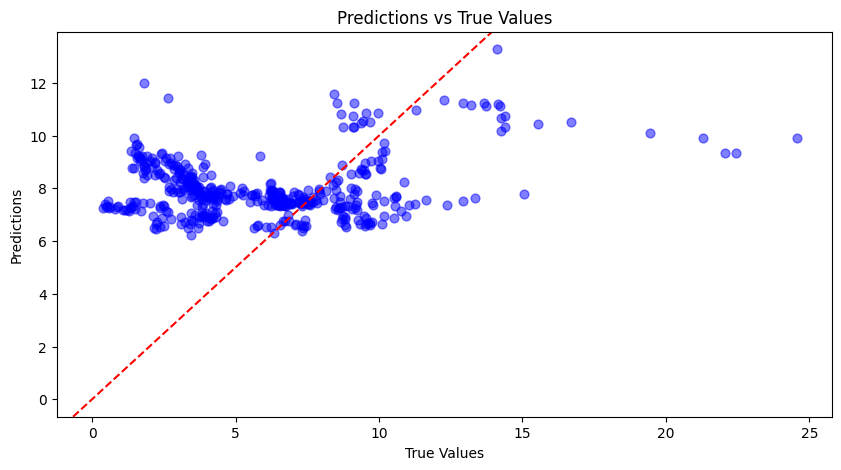

In [81]:
# plot the true vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test_fit, y_pred, c="b", s=40, alpha=0.5)
plt.axline([0, 0], [1, 1], color="red", linestyle="--")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title(f"Predictions vs True Values")
plt.show()

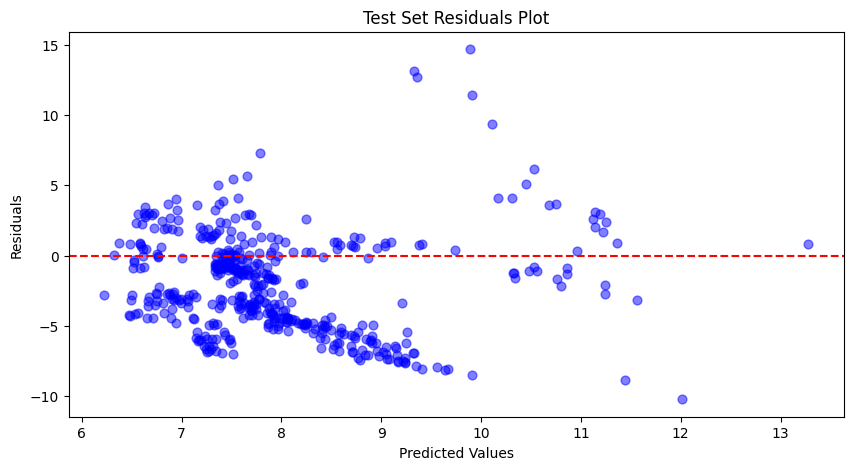

In [82]:
# plot the residuals
residuals = y_test_fit["Absorbance 254nm"] - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.scatter(y_pred.flatten(), residuals, c="b", s=40, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Test Set Residuals Plot")
plt.show()

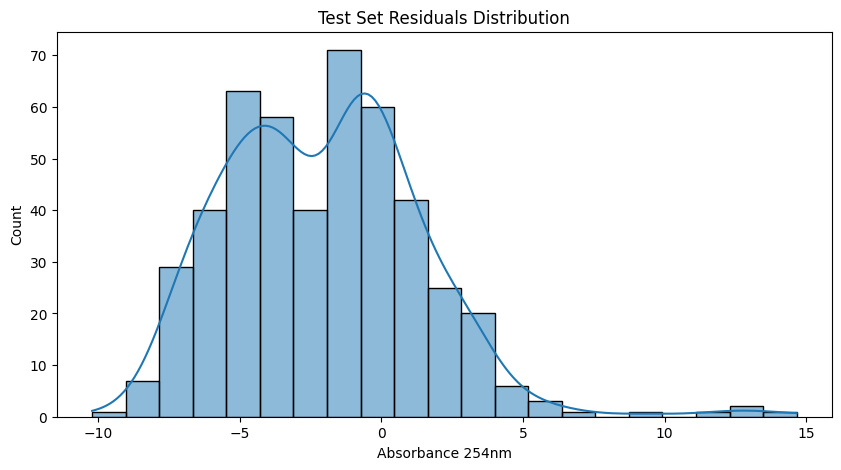

In [83]:
# plot the distribution of the residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title("Test Set Residuals Distribution")
plt.show()

In [84]:
# get training residuals
(_, train_predictions, _) = predict_with_pi(ensemble, X_train_scaled)
train_residuals = y_train_fit["Absorbance 254nm"] - train_predictions

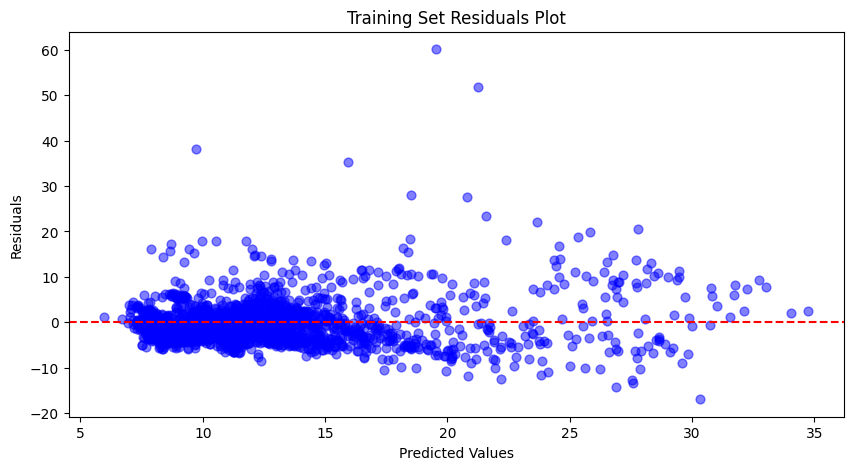

In [85]:
# plot the training residuals
plt.figure(figsize=(10, 5))
plt.scatter(
    train_predictions.flatten(), train_residuals, c="b", s=40, alpha=0.5
)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Training Set Residuals Plot")
plt.show()

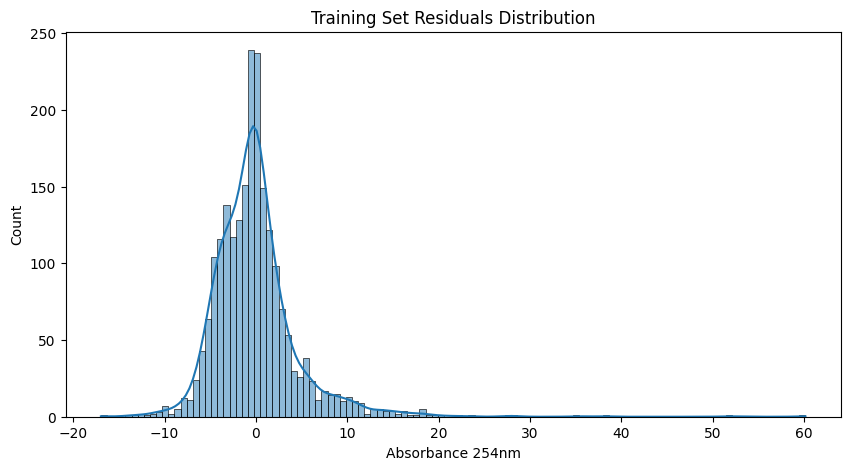

In [86]:
# plot the distribution of the training residuals
plt.figure(figsize=(10, 5))
sns.histplot(train_residuals, kde=True)
plt.title("Training Set Residuals Distribution")
plt.show()

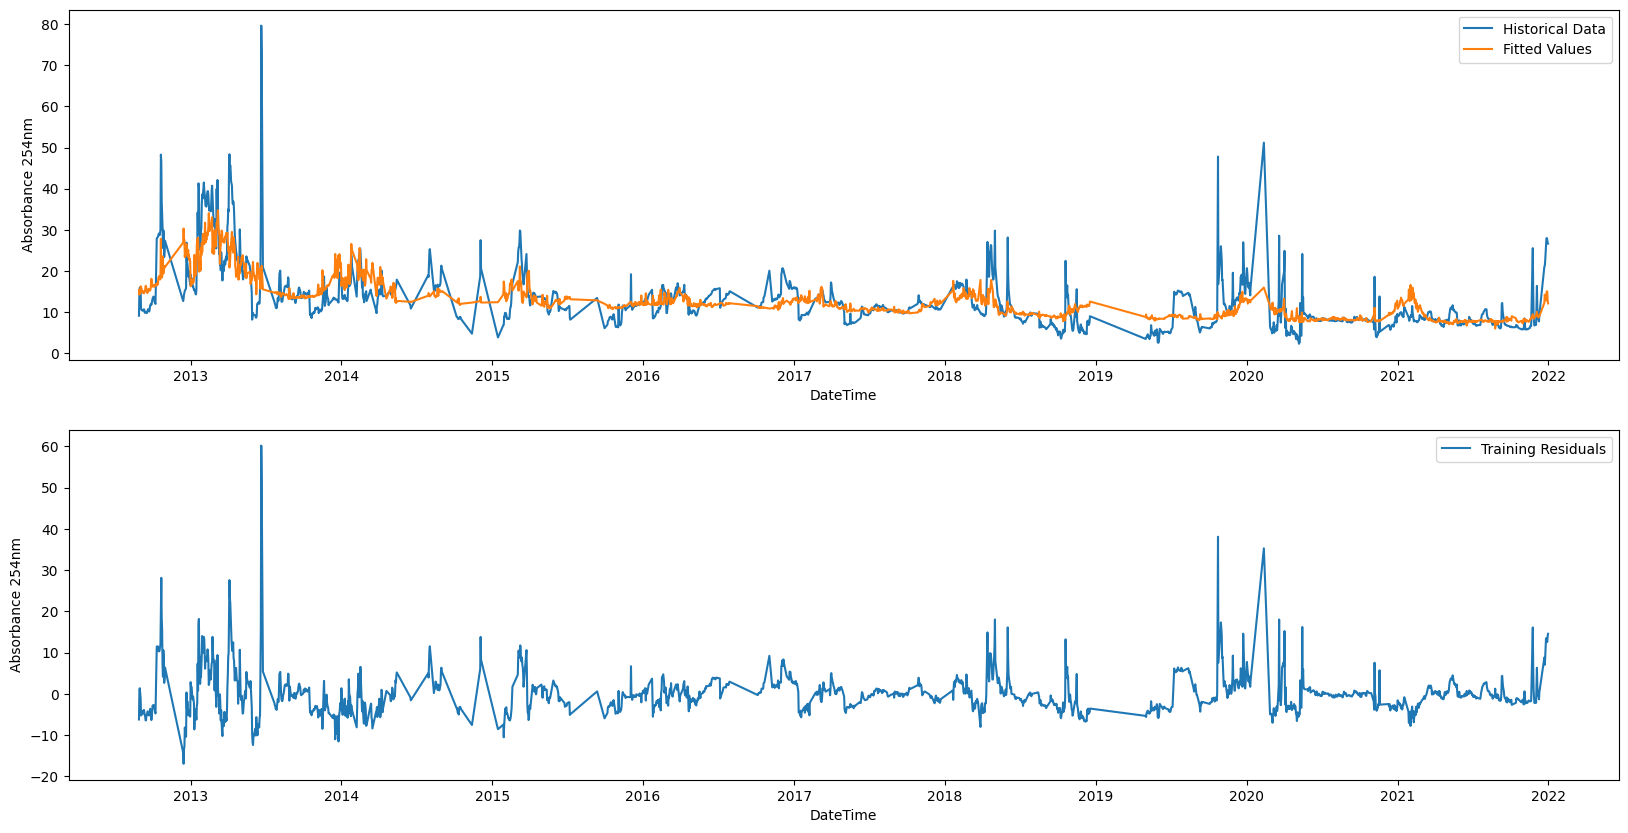

In [87]:
# plot the time series of the residuals and of the train set
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
    ax=ax[0],
)
sns.lineplot(
    x=y_train["DateTime"],
    y=train_predictions,
    label="Fitted Values",
    ax=ax[0],
)

sns.lineplot(
    x=y_train["DateTime"],
    y=train_residuals,
    label="Training Residuals",
    ax=ax[1],
)

plt.show()

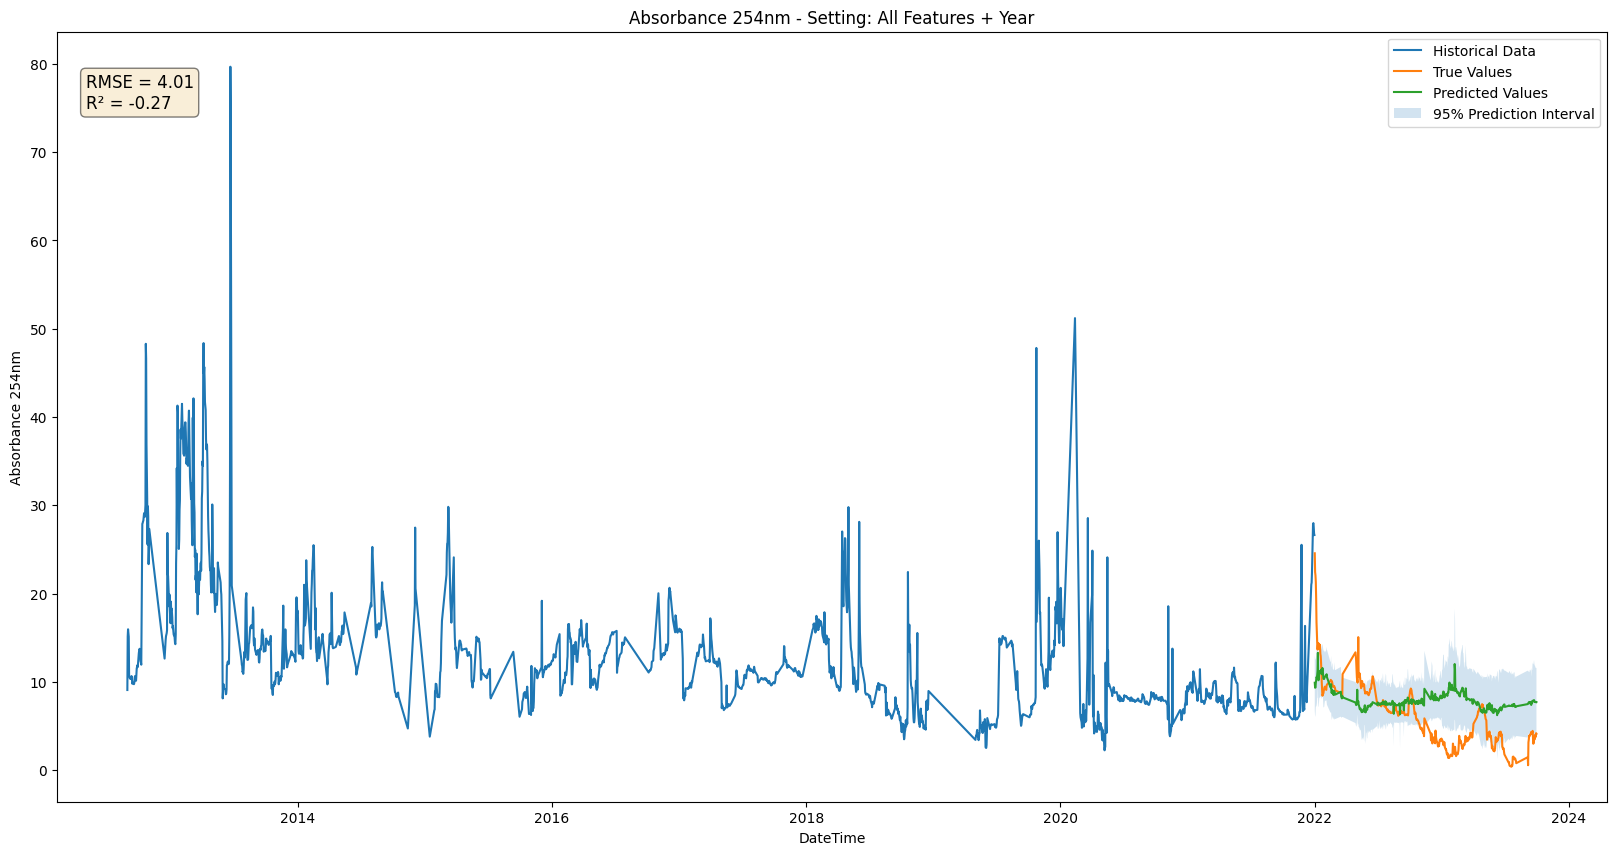

In [88]:
plt.figure(figsize=(20, 10))
sns.lineplot(
    x=y_train["DateTime"],
    y=y_train["Absorbance 254nm"],
    label="Historical Data",
)
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
)
sns.lineplot(x=y_test["DateTime"], y=y_pred, label="Predicted Values")
plt.fill_between(
    y_test["DateTime"],
    lower_bound,
    upper_bound,
    alpha=0.2,
    label="95% Prediction Interval",
)
plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"RMSE = {rmse:.2f}",
        f"R\u00b2 = {r2:.2f}",
    )
)

plt.text(
    y_train["DateTime"].iloc[0] - pd.Timedelta(days=120),
    75,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm - Setting: {setting}")

plt.legend()
plt.show()

## Store Results

In [89]:
nn_pred = y_pred
nn_lower_bound = lower_bound
nn_upper_bound = upper_bound
nn_rmse = rmse
nn_r2 = r2

# Final Plot

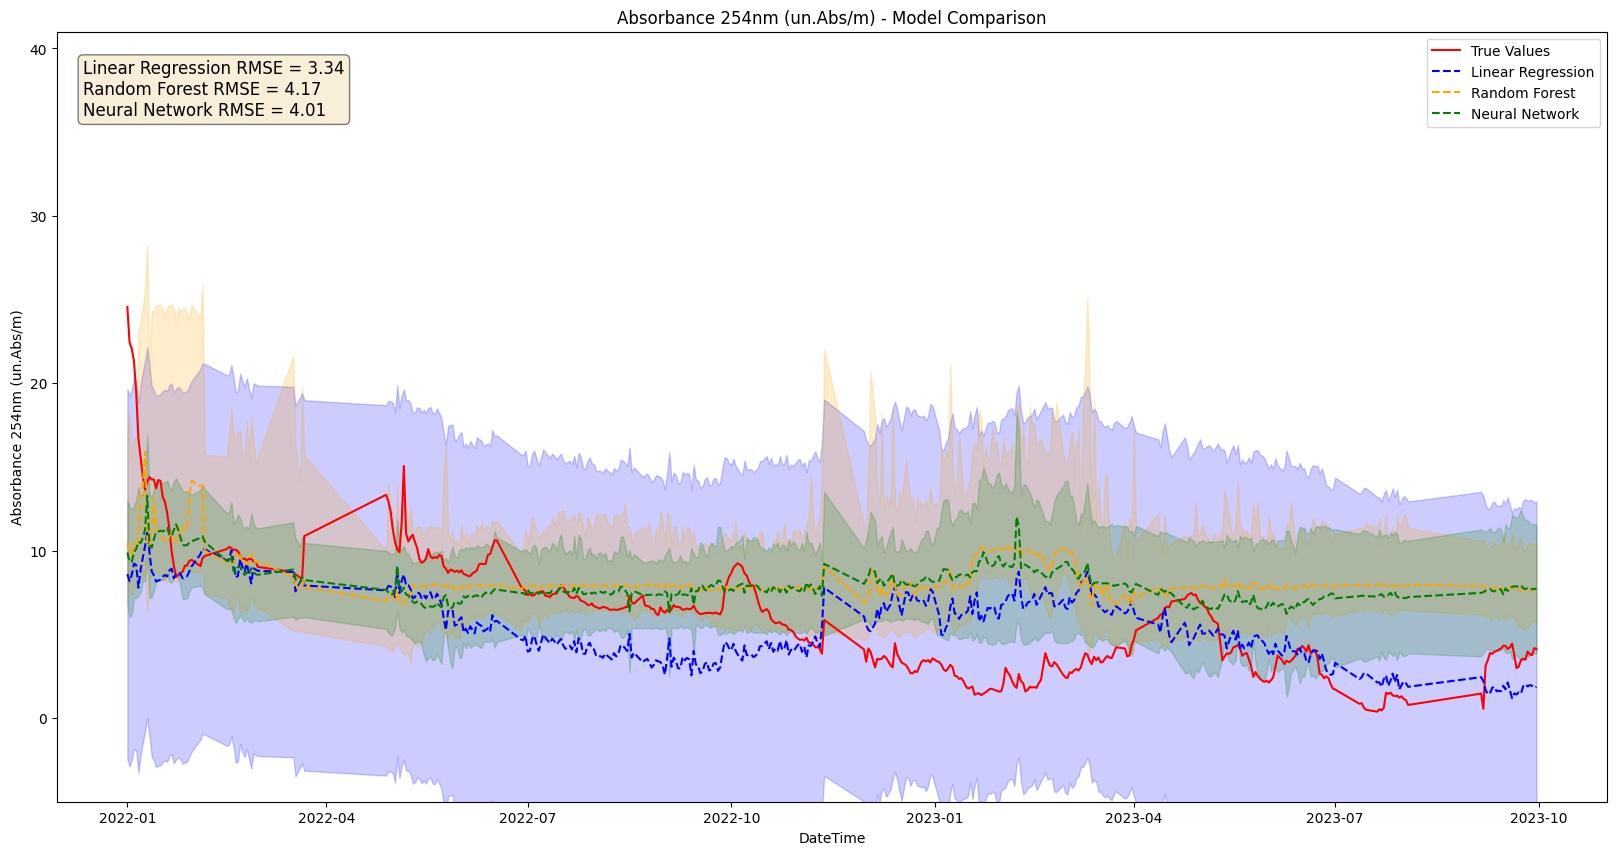

In [94]:
# create a plot for the comparison of the models
plt.figure(figsize=(20, 10))
# sns.lineplot(x=y_train['DateTime'], y=y_train['Absorbance 254nm'], label='Historical Data')
sns.lineplot(
    x=y_test["DateTime"],
    y=y_test["Absorbance 254nm"],
    label="True Values",
    color="red",
)

# Linear Regression
sns.lineplot(
    x=y_test["DateTime"],
    y=lr_pred,
    label="Linear Regression",
    linestyle="--",
    color="blue",
)
plt.fill_between(
    y_test["DateTime"],
    lr_lower_bound,
    lr_upper_bound,
    alpha=0.2,
    color="blue",
)

# Random Forest
sns.lineplot(
    x=y_test["DateTime"],
    y=rf_pred,
    label="Random Forest",
    linestyle="--",
    color="orange",
)
plt.fill_between(
    y_test["DateTime"],
    rf_lower_bound,
    rf_upper_bound,
    alpha=0.2,
    color="orange",
)

# Neural Network
sns.lineplot(
    x=y_test["DateTime"],
    y=nn_pred,
    label="Neural Network",
    linestyle="--",
    color="green",
)
plt.fill_between(
    y_test["DateTime"],
    nn_lower_bound,
    nn_upper_bound,
    alpha=0.2,
    color="green",
)

plt.ylim(-5, 41)

plt.xlabel("DateTime")
plt.ylabel("Absorbance 254nm (un.Abs/m)")

# add rmse and r2 to the plot in a box
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

text_string = "\n".join(
    (
        f"Linear Regression RMSE = {lr_rmse:.2f}",
        f"Random Forest RMSE = {rf_rmse:.2f}",
        f"Neural Network RMSE = {nn_rmse:.2f}",
    )
)

plt.text(
    y_test["DateTime"].iloc[0] - pd.Timedelta(days=20),
    36,
    s=text_string,
    fontsize=12,
    bbox=props,
)

plt.title(f"Absorbance 254nm (un.Abs/m) - Model Comparison")

plt.legend()
plt.show()